# CamVid

* UNet with MobileNetV2 & EfficientNet as encoder, with symmetrical decoder.
* Effect of bayesian inference

# Install & Import

In [ ]:
!pip install torchmetrics -q
!pip install fvcore -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
import os
import copy
import random
import json
import math
from collections import OrderedDict
from dataclasses import dataclass
from functools import partial
from datetime import date
from prettytable import PrettyTable
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn, optim, Tensor, ones_like, zeros_like
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from fvcore.nn import FlopCountAnalysis

import torchvision
from torchvision.ops import StochasticDepth
from torchvision.ops.misc import Conv2dNormActivation, SqueezeExcitation
from torchvision.datasets import VOCSegmentation
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torchsummary import summary

from fvcore.nn import FlopCountAnalysis
from torch.profiler import profile, record_function, ProfilerActivity

from typing import Any, Callable, List, Optional, Sequence, Tuple, Union, Dict
# Detect GPU and set as default device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {DEVICE}')

Using cuda:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

Mounted at /content/drive/


In [ ]:
from model.Bayesian_net import Bayesian_net
from model._Unet import _Unet
from model.MBConfig import MBConvConfig

from utils.bayes_func import bayes_eval, bayes_forward
from utils.train_transforms import HFlip, HueSatCon, Rotation, Crop, Affine, Resize, ToTensor, Normalize

# Datasets



## CamVid

In [ ]:
if 'CamVid' not in os.listdir('/content'):
  !mkdir '/content/data'
  !cp '/content/drive/MyDrive/ShorelineNet_pytorch/dataset/camvid.zip' '/content/data/'
  !unzip -q '/content/data/camvid.zip'

## Define some Global Variables

In [ ]:
# get classes for CamVid
# class_dict = pd.read_csv('/content/CamVid/class_dict.csv')

RGB2CLSNAME = {
    (128, 128, 128): "Sky",

    (0, 128, 64): "Building",
    (128, 0, 0): "Building",
    (64, 192, 0): "Building",
    (64, 0, 64): "Building",
    (192, 0, 128): "Building",

    (192, 192, 128): "Pole",
    (0, 0, 64): "Pole",

    (128, 64, 128): "Road",
    (128, 0, 192): "Road",
    (192, 0, 64): "Road",

    (0, 0, 192): "Sidewalk",
    (64, 192, 128): "Sidewalk",
    (128, 128, 192): "Sidewalk",

    (128, 128, 0): "Tree",
    (192, 192, 0): "Tree",

    (192, 128, 128): "SignSymbol",
    (128, 128, 64): "SignSymbol",
    (0, 64, 64): "SignSymbol",

    (64, 64, 128): "Fence",

    (64, 0, 128): "Car",
    (64, 128, 192): "Car",
    (192, 128, 192): "Car",
    (192, 64, 128): "Car",
    (128, 64, 64): "Car",

    (64, 64, 0): "Pedestrian",
    (192, 128, 64): "Pedestrian",
    (64, 0, 192): "Pedestrian",
    (64, 128, 64): "Pedestrian",

    (0, 128, 192): "Bicyclist",
    (192, 0, 192): "Bicyclist",

    (0, 0, 0): "Void"
}


DROP_PIX: Optional[int] = None
FILL_PIX = 11

WIDTH = 960
HEIGHT = 720

CLASSES = sorted(list(set(RGB2CLSNAME.values())))
RGB2CLASS = {rgb:{c:i for i,c in enumerate(CLASSES)}[name] for (rgb, name) in RGB2CLSNAME.items()}
CLASS2RGB = {c:rgb for (rgb, c) in RGB2CLASS.items()}

CLASS_MAP_ALL={i:c for i,c in enumerate(CLASSES)}
CLASS_MAP = copy.deepcopy(CLASS_MAP_ALL)
CLASS_MAP.pop(FILL_PIX)
NUM_CLASSES = len(CLASS_MAP.items())


## Transformations

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t((image, target))
        return image, target

### Training Transforms

Imported from local modules: `Flip`, `HueSatCon`, `Rotation`, `Crop`, `Affine`, `Resize`, `ToTensor`, `Normalize`

In [ ]:
from torch import is_tensor

class Crop(object):
    def __init__(
        self,
        scale:Optional[Tuple[float, float]]=[1.0, 1.0],
        fill_pix: Optional[int]=FILL_PIX,
    ) -> None:
        assert(scale[1] > scale[0])
        self.fill_pix = fill_pix
        self.scale = scale

    def __call__(
        self, data: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        (x, y) = data

        h, w = y.shape[1:]
        s = random.random() * (self.scale[1] - self.scale[0]) + self.scale[0]
        h_rand = random.random()
        w_rand = random.random()

        padding = (int(w_rand*(1-s)*w),
                  int(h_rand*(1-s)*h),
                  int((1-w_rand)*(1-s)*w),
                  int((1-h_rand)*(1-s)*h))

        x_crop = transforms.Pad(padding, fill=0, padding_mode='constant')
        y_crop = transforms.Pad(padding, fill=FILL_PIX, padding_mode='constant')

        x = x_crop(x)
        y = y_crop(y)

        return (x, y)

class ToDevice(object):
    def __init__(self):
      pass

    def __call__(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
      (x, y) = data
      x = x.to(DEVICE)
      y = y.to(DEVICE)

      return (x, y)

### Test set Transforms

`Normalize_test`, `Resize_test`, all would be imported if needed

These functions only operate on images, these set of augmentations are for test images with no ground truth labels

## Dataset & Dataloader

In [ ]:
class MemoryDataset(Dataset):
    def __init__(self,
                 X:Tensor,
                 y:Tensor,
                 transform:Optional[transforms.Compose]=None,
    ) -> None:
        '''
        Loads dataset from memory

        Args
        ------
        X : Tensor with shape (n, 3, H, W)
        y : Tensor with shape (n, 1, H, W)
        transforms : transforms.Compose([...])
        '''
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            # x, y = self.transform((x, y))
            x, y = self.transform(x, y) # to be consistent with torch
        return x, y

def get_train_transforms(intensity:float=1) -> transforms.Compose:
    '''
    Returns the transformations for the training set for given intensity
    '''
    z = intensity
    train_transforms = Compose([
      HFlip(prob=0.5),
      HueSatCon(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, prob=1),
      Crop((0.7, 1.3), fill_pix=FILL_PIX),
      # Affine(affine_percentage=0.2*z, shear_deg=0, fill_pix=FILL_PIX, prob=1),
      # Rotation(10*z, fill_pix=FILL_PIX, prob=1),
      # Crop(crop_percentage=1-z*0.2, prob=1),
      Resize((HEIGHT, WIDTH)),
      ToDevice(),
      # ToTensor(),
      # RandomResizedCrop((HEIGHT, WIDTH), (0.5, 2), (1, 1)),
      Normalize(),
    ])
    return train_transforms


class DatasetManager():
  '''
  Holds dataset objects in a dict and manages augmentation properties for training set
  '''
  def __init__(self, intensity: Optional[float]=1) -> None:
    train_transforms = get_train_transforms(intensity=intensity)

    val_transforms = Compose([
        # Resize((HEIGHT, WIDTH)),
        # ToTensor(),
        ToDevice(),
        Normalize(),
    ])

    test_transforms = Compose([
        # Resize_test((HEIGHT, WIDTH)),
        # ToTensor(),
        # Normalize_test()
    ])

    # train_dataset = get_train_dataset(train_transforms)
    # val_dataset = get_val_dataset(val_transforms)

    train_dataset = load_camvid_into_memory('train', train_transforms)
    val_dataset = load_camvid_into_memory('val', val_transforms)
    test_dataset = load_camvid_into_memory('test', val_transforms)

    self.datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

  def update_train_transforms(self, intensity:float=1) -> None:
    train_transforms = get_train_transforms(intensity)
    self.datasets['train'].transforms = train_transforms
    print(f'Updated training dataset augmentation intensity to {intensity}')
    return


In [ ]:
# METHODS FOR CAMVID

def load_camvid_into_memory(split:str, t:transforms.Compose)->MemoryDataset:
    root_dir = '/content/CamVid'

    H, W = (720, 960)
    n = len(os.listdir(f'{root_dir}/{split}'))
    # preallocate tensor memory
    X = torch.zeros((n, 3, H, W), dtype=torch.float, device='cpu', requires_grad=False)
    Y = torch.zeros((n, 1, H, W), dtype=torch.float, device='cpu', requires_grad=False)

    to_tensor = transforms.PILToTensor()
    # resize_x = transforms.Resize((H, W), transforms.InterpolationMode.BILINEAR, antialias=True)
    # resize_y = transforms.Resize((H, W), transforms.InterpolationMode.NEAREST, antialias=False)

    for i in tqdm(range(n)):
      filename = os.listdir(f'{root_dir}/{split}')[i]
      x_path = os.path.join(root_dir, split, filename)
      y_path = os.path.join(root_dir, f'{split}_labels', filename.split('.')[0]+'_L.png')

      x = read_image(x_path)
      y = read_image(y_path)

      # x = to_tensor(x).to(torch.int8).to(DEVICE)
      y = map_rgbLabel_to_grayscale(y)

      # x = resize_x(x)
      # y = resize_y(y)

      x = x / 255.0
      if DROP_PIX is not None:
        y = torch.where(y == DROP_PIX, torch.ones_like(y)*FILL_PIX, y)

      X[i] = x
      Y[i] = y

    return MemoryDataset(X, Y, t)

def map_rgbLabel_to_grayscale(image: np.array) -> torch.Tensor:
    '''
    Takes a (3 x w x h) int8 rgb label and returns a (1 x w x h) label
    '''
    height, width = image.shape[1], image.shape[2]
    out = torch.zeros((1, height, width), dtype=torch.int, device=image.device)

    for (rgb, cls) in RGB2CLASS.items():
      boolean_array = (image[0] == rgb[0])
      boolean_array = boolean_array * (image[1] == rgb[1])
      boolean_array = boolean_array * (image[2] == rgb[2])
      out[0, boolean_array] = cls

    return out


In [ ]:
# create dataset manager
dataset_manager = DatasetManager()

# create dataloaders
train_dataloader = DataLoader(dataset_manager.datasets['train'], batch_size=10, shuffle=True)
val_dataloader = DataLoader(dataset_manager.datasets['val'], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset_manager.datasets['test'], batch_size=1, shuffle=True)

# # note that new instances of dataloaders are generated for every training
dataloaders = {'train': train_dataloader, 'val': val_dataloader, 'test': test_dataloader}

  0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

### Visualization helpers

* `imshow_image`
* `imshow_label`
* `imshow_uncertainty`

In [ ]:
# helper functions
from matplotlib.colors import ListedColormap
colors = [CLASS2RGB[i] for i in range(NUM_CLASSES+1)]
camvid_cmap = ListedColormap([list([c/255 for c in rgb]) for rgb in colors])

def unnormalize(image: torch.tensor) -> torch.tensor:
  '''
  Reverses imageNet Normalization to [0, 1], (for visualization purposes)
  '''
  mean = [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]
  std = [1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225]
  reverse_normalize = transforms.Normalize(mean, std)

  return torch.clip(reverse_normalize(image), 0, 1)

def imshow_image(image):
  plt.imshow(unnormalize(image).permute(1, 2, 0).cpu())
  plt.axis('off')

def imshow_label(label, cmap=camvid_cmap):
  if len(label.shape) == 3:
    label = label.permute(1, 2, 0)
  elif len(label.shape) == 2:
    pass
  plt.imshow(label.cpu(), cmap=cmap, interpolation='none', vmin=0, vmax=NUM_CLASSES)
  plt.axis('off')

def imshow_uncertainty(uncertainty: Tensor, normalize=True):
  if normalize:
    u_max, u_min = uncertainty.max(), uncertainty.min()
    uncertainty = (uncertainty - u_min) / (u_max - u_min)
  if len(uncertainty.shape) == 3:
    uncertainty = uncertainty.permute(1, 2, 0)
  # TODO: normalize to 0 - 1?
  plt.imshow(uncertainty.cpu())
  plt.axis('off')

### Preview images

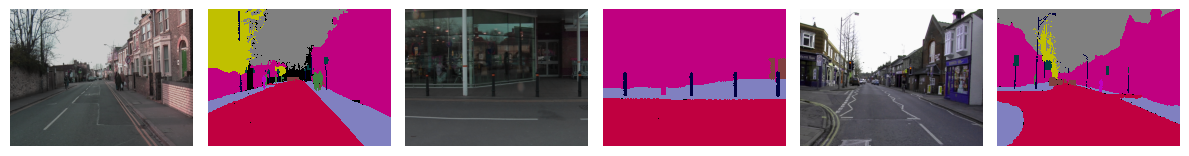

In [ ]:
split = 'train'

plt.figure(figsize=(12, 6))
for i in range(3):
  x_batch_sample, y_batch_sample = next(iter(dataloaders[split]))
  plt.subplot(1, 6, i*2+1)
  imshow_image(x_batch_sample[0])
  plt.subplot(1, 6, i*2+2)
  imshow_label(y_batch_sample[0].to(int))

# note: clipping error message can be ignored
plt.tight_layout()

In [ ]:
# xs, ys = next(iter(dataloaders['train']))
# x0, y0 = xs[0], ys[0]
# x1, y1 = xs[1], ys[1]

# plt.figure(figsize=(10, 8))
# plt.subplot(2, 2, 1)
# imshow_label(y0)

# plt.subplot(2, 2, 2)
# imshow_label(y1)

# plt.subplot(2, 2, 3)
# imshow_image(x0)
# plt.axis('off')

# plt.subplot(2, 2, 4)
# imshow_image(x1)
# plt.axis('off')

# plt.tight_layout()

# Training Architecture

Define some key classes for training
* model
* loss metric
* accuracy metric

## Network Properties

Define some helper functions to calculate:
* parameter count
* storage
* FLOPS
* CPU/GPU run time

In [ ]:
def _format_memory(nbytes):
    """Returns a formatted memory size string"""
    KB = 1024
    MB = 1024 * KB
    GB = 1024 * MB
    if abs(nbytes) >= GB:
        return f"{nbytes * 1.0 / GB:.2f} Gb"
    elif abs(nbytes) >= MB:
        return f"{nbytes * 1.0 / MB:.2f} Mb"
    elif abs(nbytes) >= KB:
        return f"{nbytes * 1.0 / KB:.2f} Kb"
    else:
        return str(nbytes) + " b"

def _format_time(time_us):
    """Defines how to format time in FunctionEvent"""
    US_IN_SECOND = 1000.0 * 1000.0
    US_IN_MS = 1000.0
    if time_us >= US_IN_SECOND:
        return f"{time_us / US_IN_SECOND:.3f}s"
    if time_us >= US_IN_MS:
        return f"{time_us / US_IN_MS:.3f}ms"
    return f"{time_us:.3f}us"

In [ ]:
# helper functions for counting parameters and storage
def count_parameters(model, print_table=False):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    if print_table:
        print(table)
    return total_params


def calculate_storage(model, print_buffer=True):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    if print_buffer:
        print(f"Buffer size: {buffer_size/1024**2:.3f} MB")

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb


In [ ]:
def count_FLOPS(net: nn.Module) -> float:
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, 'all')
    flops = FlopCountAnalysis(net, x_batch).total()

  # print(f'Flops: {flops.total()/1e9:.3f} G')
  return flops

In [ ]:
def compute_cpu_runtime_memory(net: nn.Module, n:Optional[int]=5) -> Tuple[float, float]:
  '''
  Computes the cpu and gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to('cpu')
  # MEMORY & INFERENCE TIME
  net.to('cpu')
  x_batch = x_batch.to('cpu')

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          net(x_batch)
          # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cpu_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cpu_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  return runtimes, memories



In [ ]:
def compute_gpu_runtime_memory(net: nn.Module, n:Optional[int]=5, debug=False) -> Tuple[float, float]:
  '''
  Computes the gpu run time in ms
  Returns
  -----------
  runtimes: Array[float], cpu runtime in ms
  memories: Array[float], cpu memory in mb
  '''
  x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
  # MEMORY & INFERENCE TIME
  net.to(DEVICE)
  x_batch = x_batch.to(DEVICE)

  runtimes, memories = [], []

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(False, 'all')
    for _ in tqdm(range(n)):
      with profile(activities=[ProfilerActivity.CPU,ProfilerActivity.CUDA],
                  profile_memory=True,
                  record_shapes=False) as prof:
        with record_function("model_inference"):
          net(x_batch)
          # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')
      for event in prof.key_averages():
        if event.key == 'model_inference':
          runtimes.append(event.cuda_time/1000)
        if event.key == 'aten::empty':
          memories.append(event.cuda_memory_usage/1024/1024)

  runtimes, memories = np.array(runtimes), np.array(memories)

  if debug:
    return prof

  return runtimes, memories


In [ ]:
# # MEMORY & INFERENCE TIME
# net.to('cpu')
# x_batch = x_batch.to('cpu')
# with profile(activities=[
#         ProfilerActivity.CPU], profile_memory=True, record_shapes=False) as prof:
#     net.eval()
#     net.set_bayes_mode(False, 'all')
#     with record_function("model_inference"):
#         net(x_batch)
#         # bayes_eval(net, x_batch.squeeze(0), k=10, mode='all')


In [ ]:
# for event in prof.key_averages():
#   if event.key == 'model_inference':
#     print(event)
#     print(f'CPU time: {event.cpu_time/1000}ms')
#   if event.key == 'aten::empty':
#     print(event)
#     print(f'cpu memory: {event.cpu_memory_usage/1024/1024}Mb')

## UNet

### Deconv Variations

In [ ]:
class Deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

In [ ]:
class Dw_deconv(nn.Module):
    def __init__(
        self,
        cfg,
        stochastic_depth_prob: float,
        norm_layer: Callable[..., nn.Module],
        se_layer: Optional[Callable[..., nn.Module]] = SqueezeExcitation,
        conv_layer: Optional[Callable[..., nn.Module]] = Conv2dNormActivation,
        activation_layer: Optional[Callable[..., nn.Module]] = nn.SiLU,
        use_res_connect: Optional[bool] = None,
    ) -> None:
        super().__init__()

        if not (1 <= cfg.stride <= 2):
            raise ValueError("illegal stride value")

        layers: List[nn.Module] = []

        # depthwise (can be a deconv block)
        layers.append(
            conv_layer(
                cfg.input_channels,
                cfg.input_channels,
                kernel_size=cfg.kernel,
                stride=cfg.stride,
                groups=cfg.input_channels,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
            )
        )

        # project
        layers.append(
            Conv2dNormActivation(
                cfg.input_channels,
                cfg.out_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=None,
            )
        )

        self.block = nn.Sequential(*layers)
        # if stochastic_depth_prob > 0.0:
        self.out_channels = cfg.out_channels

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        return result

### Network Config
Configuration for efficientnet and mobilenet

In [ ]:
def _efficientnet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 5, 2, 24, 40, 2, 0, 1),
        bneck_conf(6, 3, 2, 40, 80, 3, 0, 0),
        bneck_conf(6, 5, 1, 80, 112, 3, 0.5, 1),
        bneck_conf(6, 5, 2, 112, 192, 4, 0.5, 0),
        bneck_conf(6, 3, 1, 192, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting


def _mobilenet_cfg(width_mult: float, depth_mult: float) -> Sequence[MBConvConfig]:
    inverted_residual_setting = Sequence[MBConvConfig]

    bneck_conf = partial(MBConvConfig, width_mult=width_mult, depth_mult=depth_mult)
    inverted_residual_setting = [
        #         t, k, s, in, out, n, p, skip
        bneck_conf(1, 3, 1, 32, 16, 1, 0, 1),
        bneck_conf(6, 3, 2, 16, 24, 2, 0, 1),
        bneck_conf(6, 3, 2, 24, 32, 3, 0, 1),
        bneck_conf(6, 3, 2, 32, 64, 4, 0, 0),
        bneck_conf(6, 3, 1, 64, 96, 3, 0.5, 1),
        bneck_conf(6, 3, 2, 96, 160, 3, 0.5, 0),
        bneck_conf(6, 3, 1, 160, 320, 1, 0.5, 0),
    ]

    return inverted_residual_setting

network_scales = {
    "regularDecoder": (1.0, 1.0, 224),
    "mobilenet-dw": (1.0, 1.0, 224),
    "efficientnet-b0": (1.0, 1.0, 224),
    "efficientnet-b1": (1.0, 1.1, 240),
    "efficientnet-b2": (1.1, 1.2, 260),
    "efficientnet-b3": (1.2, 1.4, 300),
    "efficientnet-b4": (1.4, 1.8, 380),
    "efficientnet-b5": (1.6, 2.2, 456),
    "efficientnet-b6": (1.8, 2.6, 528),
    "efficientnet-b7": (2.0, 3.1, 600),
    "mobilenet-v2": (1.0, 1.0, 224),
    "efficientnet-b0-hswish": (1.0, 1.0, 224),
}

network_cfgs = {
    "regularDecoder": _mobilenet_cfg,
    "mobilenet-dw": _mobilenet_cfg,
    "efficientnet-b0": _efficientnet_cfg,
    "efficientnet-b1": _efficientnet_cfg,
    "efficientnet-b2": _efficientnet_cfg,
    "efficientnet-b3": _efficientnet_cfg,
    "efficientnet-b4": _efficientnet_cfg,
    "efficientnet-b5": _efficientnet_cfg,
    "efficientnet-b6": _efficientnet_cfg,
    "efficientnet-b7": _efficientnet_cfg,
    "mobilenet-v2": _mobilenet_cfg,
    "efficientnet-b0-hswish": _efficientnet_cfg,
}

### Unet

Wrapper class for building the network for a given configuration


In [ ]:
class Unet(_Unet):
    def __init__(
        self,
        encoder_name: str = "efficientnet-b0",
        input_dim: Optional[Union[int, Tuple[int, int]]] = None,
        width_mult: Optional[float] = None,
        depth_mult: Optional[float] = None,
        stochastic_depth_prob: float = 0.2,
        use_se: Optional[bool] = False,
        dropout_p: float = 0.5,
        num_classes: int = 3,
        last_channel: Optional[int] = None,  # set 0 to disable, None for 4x
        skip_mode: Optional[str] = "upsample",  # "upsample", "none", "all"
        skip_op: Optional[str] = "concat",  # "concat", "add"
        shallowDeconv: Optional[bool] = False,
        dropout_loc: Optional[str] = None,  # "last", "middle"
        constant_dropout: Optional[bool] = True,
    ) -> None:
        assert (
            encoder_name in network_cfgs.keys()
        ), f"invalid encoder_name mode {encoder_name}"

        assert skip_mode in [
            "upsample",
            "none",
            "all",
        ], f"invalid skip loc {skip_mode}"

        assert skip_op in ["concat", "add"], f"invalid skip mode {skip_op}"

        assert dropout_loc in [
            "last",
            "middle",
            None,
        ], f"invalid dropout location {dropout_loc}"

        def set_layer_dropout(cfg, constant_dropout, dropout_p) -> None:
            total_layers = len(cfg)
            for i, layer in enumerate(cfg):
                if constant_dropout:
                    layer.dropout_p = dropout_p if layer.dropout_p > 0 else 0
                else:
                    # linearly interpolate the dropout rate
                    layer.dropout_p = dropout_p * i / (total_layers - 1)

        def set_dropout(cfg, dropout_loc, dropout_p, constant_dropout=False):
            total_layers = len(cfg)

            if dropout_loc == "middle":
                # enable dropout in the middle of the network
                for i in range(total_layers - 1):
                    cfg[i].dropout_p = 0
                cfg[-1].dropout_p = dropout_p
            elif dropout_loc == "last":
                # turn off all dropout
                for layer in cfg:
                    layer.dropout_p = 0
            elif dropout_loc == "all":
                for layer in cfg:
                    layer.dropout_p = 1
            else:
                set_layer_dropout(cfg, constant_dropout, dropout_p)

        d = network_scales[encoder_name][2] if not input_dim else input_dim
        width_mult = network_scales[encoder_name][0] if not width_mult else width_mult
        depth_mult = network_scales[encoder_name][1] if not depth_mult else depth_mult
        cfg = network_cfgs[encoder_name](width_mult, depth_mult)

        if encoder_name.startswith("efficientnet"):
            use_se = True if use_se is None else use_se
            activation_layer = nn.SiLU
            if encoder_name == "efficientnet-b0-hswish":
                activation_layer = nn.Hardswish
        elif encoder_name.startswith("mobilenet"):
            use_se = False if use_se is None else use_se
            activation_layer = nn.ReLU
        elif encoder_name in ["regularDecoder", "mobilenet-dw"]:
            use_se = False
            activation_layer = nn.ReLU
        else:
            raise NotImplementedError

        # ---------- Modify Skip & Dropout ------------
        if skip_mode != "upsample":
            # overwrite default skip connections
            for i in range(len(cfg) - 1):
                cfg[i].use_skip = True if skip_mode == "all" else False

        set_dropout(cfg, dropout_loc, dropout_p, constant_dropout)
        last_dropout_p = dropout_p if dropout_loc == "last" else 0

        # ---------- Build Decoder Config ------------
        decoder_cfg = self._decoder_config(cfg, skip_op)
        if shallowDeconv:
            self._set_cfg_shallow(decoder_cfg)
        # modify decoder block
        if encoder_name == "regularDecoder":
            self._set_decoder_block(decoder_cfg, Deconv)
        elif encoder_name == "mobilenet-dw":
            self._set_decoder_block(decoder_cfg, Dw_deconv)

        super().__init__(
            encoder_cfg=cfg,
            decoder_cfg=decoder_cfg,
            input_dim=d,
            stochastic_depth_prob=stochastic_depth_prob,
            num_classes=num_classes,
            last_channel=last_channel,
            skip_mode=skip_op,
            use_se=use_se,
            activation_layer=activation_layer,
            # shallowDeconv=shallowDeconv,
            last_dropout_p=last_dropout_p,
        )

    def _set_decoder_block(self, decoder_cfg, block):
        for i, cfg in enumerate(decoder_cfg):
            decoder_cfg[i].block = block

    def _decoder_config(self, encoder_cfg, skip_op: str) -> List[MBConvConfig]:
        decoder_cfg: List[MBConvConfig] = []
        oup = encoder_cfg[0].input_channels
        skip = 0
        prev_n=1
        for (i, cfg) in enumerate(encoder_cfg):

            skip = cfg.out_channels if cfg.use_skip else 0
            cfg_copy = copy.copy(cfg)
            cfg_copy.input_channels = cfg.out_channels
            if skip_op == "concat":
                cfg_copy.input_channels += skip
            cfg_copy.out_channels = oup

            temp_n = cfg.num_layers
            cfg_copy.num_layers = prev_n
            prev_n = temp_n

            decoder_cfg.append(cfg_copy)

            oup = cfg.out_channels

        # decoder_cfg[-1].expand_ratio = 3

        return decoder_cfg[::-1]

    def _set_cfg_shallow(self, setting):
        # set n for decoder to be all 1
        for cfg in setting:
            cfg.num_layers = 1

## network instantiation

In [ ]:
# net_name = "regularDecoder"
net_name = "mobilenet-dw"
net_name = "mobilenet-v2"
# net_name = "efficientnet-b0"

net = Unet(net_name,
           input_dim=(HEIGHT, WIDTH),
           width_mult=1,
           depth_mult=1,
           dropout_p=0.3,
           constant_dropout=False,
           stochastic_depth_prob=0,
           use_se=False,
           num_classes=NUM_CLASSES,
           last_channel=0,
           shallowDeconv=False,
           dropout_loc=None,
           skip_mode='upsample',
           skip_op='concat')

print("----UNET----")
size_all_mb = calculate_storage(net)
print("model size: {:.3f}MB".format(size_all_mb))
total_params = count_parameters(net)
print(f"Total Trainable Params: {total_params/1e6 :.3f}M")

net.to(DEVICE)
print(f'moved network to {DEVICE}')

----UNET----
Buffer size: 0.239 MB
model size: 14.237MB
Total Trainable Params: 3.669M
moved network to cuda:0


In [ ]:
# runtimes, memories = compute_cpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Runtime: 416.07ms +- 53.25
# Memory: 372.54ms +- 2.28

In [ ]:
# runtimes, memories = compute_gpu_runtime_memory(net, n=5)

# print(f'Runtime: {runtimes.mean():.2f}ms +- {runtimes.std():.2f}')
# print(f'Memory: {memories.mean():.2f}Mb +- {memories.std():.2f}')

# Inverted Residual
# model size: 14.237MB
# Total Trainable Params: 3.669M
# Runtime: 11.49ms +- 0.01
# Memory: 179.39Mb +- 0.00

# Inverted Residual (0.75)
# model size: 8.021MB
# Total Trainable Params: 2.057M
# Runtime: 10.57ms +- 0.01
# Memory: 156.60Mb +- 0.00
# 51

# with SE
# model size: 17.651MB
# Total Trainable Params: 4.565M
# Runtime: 14.03ms +- 0.01
# Memory: 179.13Mb +- 0.00
# 52

# Depth-wise
# model size: 7.789MB
# Total Trainable Params: 2.004M
# Runtime: 7.89ms +- 0.01
# Memory: 125.83Mb +- 0.07
# 50

# Regular:
# model size: 12.857MB
# Total Trainable Params: 3.336M
# Runtime: 8.03ms +- 0.01
# Memory: 102.00Mb +- 0.00
# 48

In [ ]:
# FLOPS

# from fvcore.nn import FlopCountAnalysis

# x_batch = torch.randn(1, 3, HEIGHT, WIDTH).to(DEVICE)
# flops = FlopCountAnalysis(net, x_batch)

# print(f'Flops: {flops.total()/1e9:.3f} G')


In [ ]:
# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

### Dummy pass to see initial outputs

In [ ]:
# x_batch_sample, y_batch_sample = next(iter(test_dataloader))

# # net = net
# # net = training_manager.net

# with torch.no_grad():
#   net.eval()
#   net.set_bayes_mode(False, 'all')
#   plt.subplot(1, 3, 1)
#   plt.imshow(unnormalize(x_batch_sample[0]).permute(1, 2, 0).cpu())
#   plt.axis('off')

#   plt.subplot(1, 3, 2)
#   imshow_label(y_batch_sample[0])
#   plt.axis('off')
#   net.train()

#   pred = net(x_batch_sample.to(DEVICE))
#   plt.subplot(1, 3, 3)
#   imshow_label(torch.argmax(pred[0], dim=0))
#   plt.axis('off')
#   net.train()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


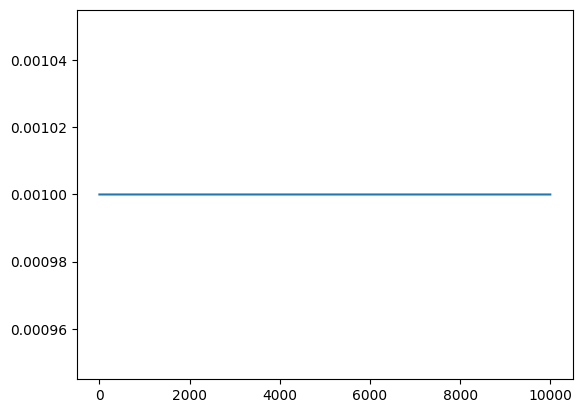

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
# # scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=10000, power=0.9)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
scheduler = optim.lr_scheduler.ConstantLR(optimizer, total_iters=10000, factor=1)

lrs = []
for _ in range(10000):
  scheduler.step()
  # lr = optimizer.param_groups[0]['lr']
  lrs.append(scheduler.get_last_lr())


plt.plot(lrs)

# plt.plot([(1-(i+1)/100)**0.9*1e-3 for i in range(100)])

In [ ]:
# batch = 5
# iterations = 5000
# training_size = 367

# epochs = iterations / math.ceil(training_size / batch)
# print(epochs)

# epochs = 300
# iterations = epochs * math.ceil(training_size / batch)
# print(iterations)

In [ ]:
del(net)

## Loss

In [ ]:
class FocalLoss(object):
  def __init__(self):
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    # place mask over placeholder pixels (loss do not propagate through them)
    mask = torch.where(y_true == FILL_PIX, zeros_like(y_true), ones_like(y_true))

    y_true = (y_true * mask).squeeze(dim=1)
    # one-hot encode labels
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=NUM_CLASSES).float().permute(0, 3, 1, 2)

    y_pred = y_pred * mask
    focal_loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (focal_loss * mask).sum() / (mask.sum()+1e-16)

    return loss

class CELoss(object):
  def __init__(self):
    self.CE_loss = torch.nn.CrossEntropyLoss(ignore_index=FILL_PIX, reduction='mean')
    pass

  def __call__(self, y_true, y_pred):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred: torch.tensor (n, c, 224, 224)
    '''
    loss = self.CE_loss(y_pred, y_true.squeeze(dim=1).long())
    return loss


## Metric

In [ ]:
# TODO: DICE accuracy

### Raw pixel accuracy

In [ ]:
class AccuracyMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax)->dict:
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class, avg, and global accuracies
    '''
    metrics = {}

    ious = self.iou(y_pred_softmax, y_true.squeeze(dim=1))
    for i, c in CLASS_MAP.items():
      metrics[f'iou/{c}'] = ious[i]
    metrics['iou/mean'] = ious.mean()

    # select most probable class
    y_pred = torch.argmax(y_pred_softmax, 1, keepdim=True)

    # compute per-class accuracy
    for i, c in CLASS_MAP.items():
      # filter gt pixels for class c
      correct_pixels = (y_true == i) * (y_pred == y_true)
      # index by the class name
      metrics[f'acc/{c}'] = correct_pixels.sum()/((y_true == i).sum() + 1e-16)

    # compute average per-class accuracy
    avg_accuracy = 0
    for a in metrics.values():
      avg_accuracy += a
    metrics['acc/avg'] = avg_accuracy / len(metrics.values())

    # compute global accuracy
    mask = y_true != FILL_PIX # binary mask
    # correct pixels
    diff = y_pred == y_true
    # filter
    metrics['acc/global'] = (diff*mask).sum() / mask.sum()

    return metrics


### IOU

In [ ]:
class IOUMetric(object):
  def __init__(self):
    self.iou = torchmetrics.classification.MulticlassJaccardIndex(num_classes=NUM_CLASSES, average='none', ignore_index=FILL_PIX).to(DEVICE)

  def __call__(self, y_true, y_pred_softmax):
    '''
    Args
    ----------
    y_true: torch.tensor (n, 1, 224, 224)
    y_pred_softmax: torch.tensor (n, c, 224, 224)

    Returns
    ----------
    accuracies: dict, containing all per-class and mean IOUs
    '''
    out = {}
    ious = self.iou(y_pred_softmax, y_true)
    for i, c in CLASS_MAP.items():
      out[c] = ious[i]
    out['mean'] = ious.mean()
    return out

# Bayesian Functions

## Bayes Forward
Imported from local modules

    Performs k forward passes with stochastic regularisation

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor (k x c x W x H) buffer

    Returns
    -----------
    y_softmax            : torch.tensor (c x W x H)
    y_pred               : torch.tensor (W x H)
    y_pred_std_per_class : torch.tensor (c x W x H)
    y_pred_std_avg       : torch.tensor (W x H)

## Bayes Evaluation Pass

Only outputs the final predictions, used for inference on test set & saves some computation

    Performs k forward passes with dropout layers, returns prediction

    Args
    -----------
    net: nn.Module
    X  : torch.tensor (c x W x H), a single input image
    k  : int, indicating number of repeated forwards passes
    mode: str, indicating which bayesian mode to use
    buffer (optional): torch.tensor(k x c x W x H) buffer

    Returns
    -----------
    y_pred               : torch.tensor (W x H)

## Calibration

In [ ]:
def compute_calibration_statistics(total_counts, total_corrects, confs):
  '''
  Computes the calibration statistics given the buckets
  '''
  num_buckets = len(total_counts)
  n = total_counts.sum()

  step = 1/num_buckets

  ECE = 0
  MCE = 0

  for i in range(num_buckets):
    conf = confs[i]
    acc = total_corrects[i]/total_counts[i]
    calibration_error = total_counts[i] * np.absolute(conf - acc)

    ECE += calibration_error / n
    MCE = max(calibration_error / n, MCE)

  return ECE, MCE

In [ ]:
def get_calibration(net:nn.Module,
                    dataloader:DataLoader,
                    k:int,
                    mode: Optional[str]='all',
                    num_buckets:Optional[int]=10
):
  '''
  Returns array of buckets for the reliability plot

  Args
  -----------
  net: nn.Module
  dataloader: torch.Dataloader
  k: set to 0 for regular forward pass, or larger than 0 for bayes forward pass
  mode: sets the mode of which bayesian inference to perform
  num_buckets: number of buckets to separate between 0 to 100 probabiliy

  Returns
  -----------
  total_counts: (num_buckets, ) np array, number of instances with confidence in the bucket
  total_corrects: (num_buckets, ) np array, number of correct instances with confidence in the bucket
  total_confs: (num_buckets, ) np array, the confidence score for each bucket by the network
  '''
  total_counts = np.array([1e-16]*num_buckets)
  total_corrects = np.array([0]*num_buckets)
  total_confs = np.array([0]*num_buckets)

  # loop through images and make predictions
  for X_batch, y_batch in tqdm(dataloader):
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        net.eval()
        # bayes forward pass
        if k == 0:
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
        elif k > 0:
          net.set_bayes_mode(True, mode)
          y_softmax, _, _, _ = bayes_forward(net, x, k)

        counts, corrects, conf = get_calibration_per_prediction(y, y_softmax, num_buckets)
        total_counts += counts
        total_corrects += corrects
        total_confs += conf

  # buckets = total_corrects / total_counts

  return total_counts, total_corrects, total_confs/total_counts

def get_calibration_per_prediction(y_gt, y_softmax, num_buckets):
  '''
  Computes reliability values for each image

  Args
  -----------
  y_gt: torch.tensor (1 x W x H)
  y_softmax: torch.tensor (c x W x H)
  num_buckets: int

  Returns
  -----------
  counts: np.array (num_buckets, ) counts in each bin
  correct: np.array (num_buckets, ) number of corrects in each bin
  conf: np.array (num_buckets, ) the average confidence p
  '''
  mask = (y_gt!=FILL_PIX).to(float)
  out_count = np.array([0]*num_buckets)
  out_correct = np.array([0]*num_buckets)
  out_conf = np.array([0]*num_buckets)
  step = 1/num_buckets
  # get probability and prediction
  y_prob, y_pred = torch.max(y_softmax, dim=0)
  indices = y_prob // step

  for i in range(num_buckets):
    out_count[i] += (mask*(indices==i)).sum()
    out_correct[i] += (mask*(indices==i)*(y_pred==y_gt)).sum()
    out_conf[i] += (mask*(indices==i)*y_prob).sum()

  return out_count, out_correct, out_conf


## Epistemic & Aleatoric Uncertainties

In [ ]:
def compute_bayesian_uncertainties(net, X:Tensor, k:int, mode:Optional[str]='all')->Tuple[Tensor, Tensor]:
  '''
  Performs k forward passes with dropout layers, returns prediction

  Args
  -----------
  net: nn.Module
  X  : torch.tensor (c x W x H), a single input image
  k  : int, indicating number of repeated forwards passes
  mode: str, indicating what mode of bayesian inference to do

  Returns
  -----------
  predictive_entropy: torch.tensor (W x H)
  mutual_information: torch.tensor (W x H)
  y_pred: torch.tensor (W x H)
  '''
  assert (k>=1)

  with torch.no_grad():
    net.eval()
    net.set_bayes_mode(True, mode)
    # write image to buffer
    buffer = X.unsqueeze(0).repeat(k, 1, 1, 1)
    for i in range(k):
      buffer[i] = X

    eps = 1e-8
    y_logits = net(buffer)
    y_softmax = y_logits.softmax(dim=1) # k x c x W x H
    avg_over_k = y_softmax.mean(dim=0) # c x W x H
    predictive_entropy = -(avg_over_k * torch.log(avg_over_k+eps)).sum(dim=0) # W x H
    mutual_information = predictive_entropy + 1/k * (y_softmax*torch.log(y_softmax+eps)).sum(dim=0).sum(dim=0) # W x H

    epistemic_uncertainty = mutual_information
    aleatoric_uncertainty = predictive_entropy - epistemic_uncertainty

    y_pred = torch.argmax(avg_over_k, dim=0)

  return predictive_entropy, mutual_information, y_pred

## PAvPU

In [ ]:
def PAvPU(gt: Tensor,
          pred: Tensor,
          uncertainty: Tensor,
          min_uncertainty: float,
          max_uncertainty: float,
          acc_threshold: Optional[float]=0.5,
          window: Optional[int]=4,
          num_buckets=100)->float:
  '''
  Computes PAvPU for a single image
  Args
  --------
  gt: Tensor (1 x w x h)
  pred: Tensor (1 x w x h)
  uncertainty: Tensor (1 x w x h)
  acc_threshold: float indicating threshold for correct/wrong
  window: slider size
  Returns
  --------
  pa: List[float] P(accurate|certain)
  pu: List[float] P(inaccurate|uncertain)
  PAvPU: List[float]
  '''

  pas, pus, pavpus = [], [], []


  def compute_pavpu(a, mask, percentage_certain, p_threshold):
    c = (percentage_certain < p_threshold).to(int)
    u = (percentage_certain >= p_threshold).to(int)

    nac = (a * c * mask).sum()
    nic = ((1-a) * c * mask).sum()
    niu = ((1-a) * (1-c) * mask).sum()
    nau = (a * (1-c) * mask).sum()

    pa = nac/(nac + nic + 1e-16)
    pu = niu/(nic + niu + 1e-16)

    pavpu = (nac + niu) / (nac + nau + nic + niu + 1e-16)

    return pa.item(), pu.item(), pavpu.item()

  sum_pool = nn.AvgPool2d(kernel_size=window, stride=window, divisor_override=1)

  # valid pixels
  mask = (gt!=FILL_PIX).to(float)
  # indicates no. of "active pixels" in the pooled dimension
  active_pixels = (sum_pool(mask).to(float))

  # turn off outputs on invalid pixels so they don't count towards the sum
  corrects = (pred==gt)*mask.to(float)
  uncertainty = (uncertainty*mask).to(float)

  norm_factor = uncertainty.sum()

  # compute average per patch
  percentage_correct = sum_pool(corrects) / (active_pixels+1e-16)
  percentage_certain = sum_pool(uncertainty) / (active_pixels+1e-16)

  # percentage_certain /= norm_factor

  a = (percentage_correct >= acc_threshold).to(int)
  i = (percentage_correct == acc_threshold).to(int)

  # indicates patches with no valid pixels
  binary_mask = (active_pixels!=0).to(int)
  # print(binary_mask.sum())

  for n in range(num_buckets):
    step = n * 1/num_buckets

    max_uncertainty, min_uncertainty = percentage_certain.max(), percentage_certain.min()

    uncertainty_threshold = min_uncertainty + step * (max_uncertainty - min_uncertainty)
    # uncertainty_threshold = step

    pa, pu, pavpu = compute_pavpu(a, binary_mask, percentage_certain, uncertainty_threshold)

    pas.append(pa)
    pus.append(pu)
    pavpus.append(pavpu)

  return pas, pus, pavpus



In [ ]:
def compute_average_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
)->Tuple[float, float, float]:

  if not dataloader:
    dataloader = val_dataloader

  avg_wa_p, avg_entropy, avg_mutual_info = 0, 0, 0
  with torch.no_grad():
    for X_batch, y_batch in tqdm(dataloader):
      # force loop to be over single images
        for (x, y) in zip(X_batch, y_batch):
          mask = (y!=FILL_PIX).to(float) # (w x h)
          # mask = torch.ones_like(y).to(float)

          # normal forward pass
          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
          # compute entropy (adjusted by fill pix)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          avg_wa_p += entropy.sum() / (mask.sum() + 1e-16)

          # bayes pass
          net.eval()
          net.set_bayes_mode(True, 'all')

          entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')
          # buffer = x.unsqueeze(0).repeat(k, 1, 1, 1) # (k x 3 x w x h)
          # # softmax averaged across k forward passes
          # y_softmax = net(buffer).softmax(dim=1).mean(dim=0) # (11 x w x h)
          # # compute entropy (adjusted by fill pix)
          # entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) * mask # (w x h)
          # print(y_softmax)
          entropy = entropy * mask
          mutual_info = mutual_info * mask

          avg_entropy += entropy.sum() / (mask.sum() + 1e-16)
          avg_mutual_info += mutual_info.sum() / (mask.sum() + 1e-16)

  avg_wa_p = avg_wa_p / len(dataloader.dataset)
  avg_entropy = avg_entropy / len(dataloader.dataset)
  avg_mutual_info = avg_mutual_info / len(dataloader.dataset)

  return avg_wa_p.item(), avg_entropy.item(), avg_mutual_info.item()


In [ ]:
def compute_min_max_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader

    output = {'wa': [np.inf, -np.inf],
              'PE': [np.inf, -np.inf],
              'MI': [np.inf, -np.inf],}

    def parse_min(tensor, mask):
        return torch.where(mask == 1, tensor, torch.inf).min()

    def parse_max(tensor, mask):
        return torch.where(mask == 1, tensor, -torch.inf).max()

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] = min(output['wa'][0], parse_min(entropy, mask))
            output['wa'][1] = max(output['wa'][1], parse_max(entropy, mask))

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = min(output['PE'][0], parse_min(entropy, mask))
            output['PE'][1] = max(output['PE'][1], parse_max(entropy, mask))
            output['MI'][0] = min(output['MI'][0], parse_min(mutual_info, mask))
            output['MI'][1] = max(output['MI'][1], parse_max(mutual_info, mask))

      return output


In [ ]:
def compute_mean_std_uncertainty(
    net,
    dataloader:DataLoader=None,
    k:Optional[int]=10,
) -> Dict[str, Tuple[float, float]]:
    if not dataloader:
      dataloader = val_dataloader
    #                x  x^2
    track  = {'wa': [0, 0],
              'PE': [0, 0],
              'MI': [0, 0],}

    with torch.no_grad():
      for X_batch, y_batch in tqdm(dataloader):
        # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            mask = (y!=FILL_PIX).to(float) # (w x h)

            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0) # (11 x w x h)
            # compute entropy (adjusted by fill pix)
            entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0) # (w x h)

            output['wa'][0] += (entropy * mask).sum()
            output['wa'][1] += (entropy **2 * mask).sum()

            # bayes pass
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, _ = compute_bayesian_uncertainties(net, x, k, 'all')

            output['PE'][0] = (entropy * mask).sum()
            output['PE'][1] = (entropy **2 * mask).sum()
            output['MI'][0] = (mutual_info * mask).sum()
            output['MI'][1] = (mutual_info **2 * mask).sum()

      n = len(dataloader.dataset)
      output = {}
      for k, (x, x2) in track.items():
        output[k] = [x/n, (x2/n - (x/n)**2)**0.5]

      return output

In [ ]:
def compute_auc(ys, xrange:Optional[int]=1):
  n = len(ys)
  step = xrange/n

  auc = 0
  prev = ys[0]
  for i in range(n):
    curr = ys[i]
    area = (curr+prev)/2 * step
    auc += area
    prev = curr

  return auc

# Training Manager

This is the class responsible handling training, evaluation, recording values during training, etc.

In [ ]:
class TrainingManager():
  def __init__(self, datasets, config):
    self.datasets = datasets
    self.config = config

    self._load()
    # self.net = copy.deepcopy(net).to(DEVICE) # no longer importing net

  def _load(self):
    # hyperparameters from config
    self.batch_size = self.config.get('batch_size', 16)
    self.total_epochs = self.config.get('total_epochs', 100)
    self.weight_decay = self.config.get('weight_decay', 1e-4)
    self.lr = self.config.get('lr', 1e-4)
    self.k = self.config.get('k', 10)
    self.patience = self.config.get('patience', 20)
    self.track_metrics = self.config.get('track_metrics', ['loss'])
    self.num_classes = self.config.get('num_classes', 3)
    self.bayes_mode = self.config.get('bayes_mode', 'all')
    self.eval_subset = self.config.get('eval_subset', None)


    # initiate dataloader
    self.dataloaders = {'train': DataLoader(self.datasets['train'], batch_size=self.batch_size, shuffle=True),
                        'val': DataLoader(self.datasets['val'], batch_size=1, shuffle=True),
                        'test': DataLoader(self.datasets['test'], batch_size=1, shuffle=False)}

    # initiate net
    self.net = Unet(encoder_name=self.config['model'],
                    num_classes=self.config['num_classes'],
                    width_mult=self.config.get('width_mult', None),
                    depth_mult=self.config.get('depth_mult', None),
                    input_dim=self.config['input_dim'],
                    stochastic_depth_prob=self.config['stochastic_depth_prob'],
                    use_se=self.config.get('use_se', None),
                    dropout_p=self.config['dropout_p'],
                    constant_dropout = self.config['dropout_mode'] == 'constant',
                    last_channel=self.config.get('last_channel', None),
                    skip_mode=self.config.get('skip_mode', 'upsample'),
                    skip_op=self.config.get('skip_op', 'concat'),
                    shallowDeconv=self.config.get('shallowDeconv', False),
                    dropout_loc=self.config.get('dropout_loc', None),
                    )

    print("----UNET----")
    size_all_mb = calculate_storage(self.net)
    print("model size: {:.3f}MB".format(size_all_mb))
    total_params = count_parameters(self.net)
    print(f"Total Trainable Params: {total_params/1e6 :.3f}M")
    print('------------')

    self.net.to(DEVICE)
    self.best_net = None

    self.loss_func = self.config.get('loss', 'CE')
    if self.loss_func == 'Focal':
      self.criterion = FocalLoss()
    elif self.loss_func == 'CE':
      self.criterion = CELoss()
    else:
      print('Invalid loss function')
      raise ValueError()

    self.metric = AccuracyMetric()

    self.optimizer = torch.optim.RMSprop(self.net.parameters(), weight_decay=self.weight_decay, lr=self.lr)
    if self.config['scheduler'] == 'poly':
      # total_iters = self.total_epochs * math.ceil(len(self.dataloaders['train'].dataset)/self.batch_size)
      total_iters = self.total_epochs
      self.scheduler = optim.lr_scheduler.PolynomialLR(self.optimizer, total_iters=total_iters, power=0.9)
      print(f'Training for {total_iters} iterations')
    elif self.config['scheduler'] == 'exp':
      self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.995)
      self.total_epochs = 10000
    else:
      self.scheduler = optim.lr_scheduler.ConstantLR(self.optimizer, total_iters=self.total_epochs, factor=1)
    # TODO: add other scheduler options, or handle no scheduler

    self.epoch = 0
    self.early_stop = False
    self.history = {'lr': []}

    for split in ['train', 'val', 'val_b']:
      self.history[f'loss/{split}'] = []
      self.history[f'acc/avg/{split}'] = []
      self.history[f'acc/global/{split}'] = []
      self.history[f'iou/mean/{split}'] = []
      for c in CLASS_MAP.values():
        self.history[f'acc/{c}/{split}'] = []
        self.history[f'iou/{c}/{split}'] = []

    self.history['best_val_loss'] = 999
    self.history['best_val_miou'] = 0
    self.history['best_val_acc'] = 0
    self.history['best_epoch'] = 0
    self.patience_count = 0

  def train(self, epochs, eval_mode='bayes'):
    # torch.cuda.empty_cache() # helps clearing RAM
    # self.net.train()
    # self.net.set_bayes_mode(True, net.set_bayes_mode)
    self.early_stop=False
    for e in range(epochs):
      self.net.train()
      self.net.set_bayes_mode(True, 'all')
      # create temporary dict to hold epoch results for train set
      train_epoch_logs = {'loss': 0, 'acc/avg': 0, 'acc/global': 0, 'iou/mean': 0}
      for c in CLASS_MAP.values():
        train_epoch_logs[f'acc/{c}'] = 0
        train_epoch_logs[f'iou/{c}'] = 0

      for X_batch, y_batch in tqdm(self.dataloaders['train']):
        self.optimizer.zero_grad()

        # forward pss
        y_logits = self.net(X_batch)

        # compute loss
        loss = self.criterion(y_batch, y_logits)
        accs = self.metric(y_batch, y_logits)

        # back prop
        loss.backward()

        # update parameters
        self.optimizer.step()

        # log batch loss and accuracy
        batch_size = X_batch.shape[0]
        train_epoch_logs['loss'] += loss.item() * batch_size
        for k, v in accs.items():
          train_epoch_logs[k] += v.item() * batch_size

      self.scheduler.step()
      n_train = len(self.dataloaders['train'].dataset)
      train_epoch_logs = {k:v/n_train for k, v in train_epoch_logs.items()}
      # log epoch loss and accuracy
      for k,v in train_epoch_logs.items():
        self.history[f'{k}/train'].append(v)

      val_loss, val_accs, val_loss_b, val_accs_b = self.evaluate('val', eval_mode, subset=self.eval_subset)

      if val_loss is not None:
        self.history['loss/val'].append(val_loss)
        for name in val_accs.keys():
          self.history[f'{name}/val'].append(val_accs.get(name, 0))

      if val_loss_b is not None:
        self.history['loss/val_b'].append(val_loss_b)
        for name in val_accs_b.keys():
          self.history[f'{name}/val_b'].append(val_accs_b.get(name, 0))

      self._update_best_net()
      self.history['lr'].append(self.scheduler.get_last_lr()[0])
      self.epoch += 1

      print(f'Epoch {self.epoch}')
      print(f"Train: Acc(g) = {self.history['acc/global/train'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/train'][-1]*100:.4f}, mIOU = {self.history['iou/mean/train'][-1]*100:.4f}, Loss = {self.history['loss/train'][-1]:.4f}")
      print(f"Val: Acc(g) = {self.history['acc/global/val'][-1]*100:.4f}, Acc(c) = {self.history['acc/avg/val'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val'][-1]*100:.4f}, Loss = {self.history['loss/val'][-1]:.4f}")
      if eval_mode == 'all' or eval_mode == 'bayes':
        print(f"Bayes_validation: Acc = {self.history['acc/global/val_b'][-1]*100:.4f}, mIOU = {self.history['iou/mean/val_b'][-1]*100:.4f}, Loss = {self.history['loss/val_b'][-1]:.4f}")

      if self.early_stop or self.epoch >= self.total_epochs:
        print('finished training')
        return

  # def _lr(self)->float:
  #   return self.optimizer.param_groups[0]['lr']

  def _set_lr(self, lr:float)->None:
    self.optimizer.param_groups[0]['lr'] = lr

  def _update_best_net(self, min_epochs=10):
    # metric = 'loss/val'
    if self.epoch < min_epochs or len(self.history['loss/val']) <= 1:
      return

    update_best = False
    loss = self.history['loss/val'][-1]
    acc = self.history['acc/avg/val'][-1]
    miou = self.history['iou/mean/val'][-1]

    curr_min_loss = self.history.get('best_val_loss', 999)
    curr_max_acc = self.history.get('best_val_acc', 0)
    curr_max_miou = self.history.get('best_val_miou', 0)

    if 'loss' in self.track_metrics and loss < curr_min_loss:
      print(f'loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %')
      self.history['best_val_loss'] = loss
      update_best = True

    if 'acc' in self.track_metrics and acc > curr_max_acc:
      print(f'acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %')
      self.history['best_val_acc'] = acc
      update_best = True

    if 'miou' in self.track_metrics and miou > curr_max_miou:
      print(f'miou increased by {(miou-curr_max_miou)/(curr_max_miou+1e-16)*100 :.3f} %')
      self.history['best_val_miou'] = miou
      update_best = True

    if miou < curr_max_miou and acc < curr_max_acc:
      self.patience_count += 1

    if update_best:
      print('saving best net...')
      self.best_net = copy.deepcopy(self.net)
      self.history['best_epoch'] = self.epoch
      self.patience_count = 0

    if self.patience_count >= self.patience:
      print(f'Acc(c) or miou have not improved for {self.patience} epochs, terminate training')
      self.early_stop = True

  def _evaluate_regular(self,
                        dataloader:DataLoader,
                        net:Optional[nn.Module]=None
  ) -> Tuple[int, dict[str, float]]:
    net = net if net != None else self.net
    net.eval()
    net.set_bayes_mode(False, 'all')
    total_loss = 0
    total_accs = {}
    with torch.no_grad():
      for X, y in dataloader:
        # forward pss
        y_pred = net(X)
        # compute loss & acc
        loss = self.criterion(y, y_pred)
        accs = self.metric(y, y_pred)
        total_loss += loss * len(X)

        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc * len(X)

    n = len(dataloader.dataset)
    loss = total_loss.item()/n
    accs = {k: v.item()/n for k, v in total_accs.items()}

    return loss, accs

  def _evaluate_bayes(self, dataloader, k=None, net=None):
    net = net if net != None else self.net

    if k == None:
      k = self.k

    h, w = self.config['input_dim']
    buffer_tensor = torch.empty(size=(k, 3, h, w), dtype=torch.float32, device=DEVICE)

    total_loss = 0
    total_accs = {}
    for X_batch, y_batch in dataloader:
    # force loop to be over single images
      for (x, y) in zip(X_batch, y_batch):
        # bayes forward pass
        y_logits, _, _, _ = bayes_forward(net, x, k, self.bayes_mode, buffer_tensor)
        y_logits = y_logits.unsqueeze(0)
        y = y.unsqueeze(0)
        # compute loss & acc
        loss = self.criterion(y, y_logits)
        accs = self.metric(y, y_logits)

        total_loss += loss
        for name, acc in accs.items():
          if name not in total_accs.keys():
            total_accs[name] = 0
          total_accs[name] += acc

    n = len(dataloader.dataset)
    return total_loss.item()/n, {k: v.item()/n for k, v in total_accs.items()}

  def evaluate(self,
               eval_dataset:str='val',
               mode:str='bayes',
               subset:Optional[int]=None,
               k:Optional[int]=None
    ) -> Tuple[int, dict, int, dict]:
    assert (eval_dataset in ['val', 'test', 'train'])
    assert (mode in ['regular', 'bayes', 'all', 'none'])

    temp_dict = {}
    for c in CLASS_MAP.values():
      temp_dict[f'acc/{c}'] = 0
      temp_dict[f'iou/{c}'] = 0
    temp_dict['acc/avg'] = 0
    temp_dict['acc/global'] = 0
    temp_dict['iou/mean'] = 0

    # generate subset
    if not subset:
      dataloader = self.dataloaders[eval_dataset]
    else:
      indices = torch.randperm(len(self.datasets[eval_dataset]))[:subset]
      sub_eval_dataset = torch.utils.data.Subset(self.datasets[eval_dataset], indices)
      dataloader = DataLoader(sub_eval_dataset, batch_size=1, shuffle=True)

    # initiate temporary values
    loss, accs, loss_b, accs_b = 0, temp_dict, 0, temp_dict
    if mode == 'regular':
      loss, accs = self._evaluate_regular(dataloader)
    elif mode == 'bayes':
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    elif mode == 'all':
       # TODO: if this is mode used often it should be refactored
      loss, accs = self._evaluate_regular(dataloader)
      loss_b, accs_b = self._evaluate_bayes(dataloader, k=k)
    else:
      return

    return loss, accs, loss_b, accs_b

  def load(self, directory, load_best=False):
    self._load_config_from_dir(directory)
    self._load_network_from_dir(directory, load_best)
    self._load_history_from_dir(directory)

    return

  def _load_config_from_dir(self, directory):
    print('Loading config...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    config_path = os.path.join(root_dir, directory, 'config.json')
    with open(config_path) as f:
      self.config = json.load(f)
    if type(self.config['input_dim']) is list:
      dim1, dim2 = self.config['input_dim']
      # rewrite as tuple
      self.config['input_dim'] = (dim1, dim2)
    self._load()
    return

  def _load_network_from_dir(self, directory, load_best=False):
    print('Loading network weights...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    if 'model.pt' not in os.listdir(os.path.join(root_dir, directory)):
      print('No trained weights found, using untrained network')
    else:
      # load network
      if load_best:
        ckpt_path = os.path.join(root_dir, directory, 'model_best.pt')
      else:
        ckpt_path = os.path.join(root_dir, directory, 'model.pt')
      ckpt = torch.load(os.path.join(ckpt_path), map_location=DEVICE)
      self.net.load_state_dict(ckpt)
    print(f'Loaded network at {ckpt_path}')
    return

  def _load_history_from_dir(self, directory):
    print('Loading history...')
    root_dir = '/content/drive/MyDrive/ShorelineNet_pytorch/results/'
    history_path = os.path.join(root_dir, directory, 'history.json')
    with open(history_path) as f:
      self.history = json.load(f)
    self.epoch = self.history['epoch']

    print(f'loaded network trained for {self.epoch} epochs')


# Results Manager

In [ ]:
class ResultsManager():
  def __init__(self, training_manager:TrainingManager):
    self.training_manager = training_manager
    self.history = training_manager.history
    self.config = training_manager.config

    self.directory = self._create_experiment_dir()
    self._save_config()

  def _create_experiment_dir(self) -> str:
    dataset = self.config.get("dataset", 'camvid')
    result_dir = f'/content/drive/MyDrive/ShorelineNet_pytorch/results/{dataset}/'
    exp = self.config['experiment']

    experiment_dir = os.path.join(result_dir, exp)

    if exp not in os.listdir(result_dir):
      os.mkdir(experiment_dir)
      print(f'created directory {experiment_dir}')
    else:
      num_items = len(os.listdir(experiment_dir))
      if num_items > 0:
        print('Warning: duplicate experiment name!')
        print(f'Directory at {experiment_dir} already exists and contains {num_items} items')

    return experiment_dir

  def _save_model(self, save_best:Optional[bool]=True):
    print(f'saving model at {self.training_manager.epoch} epochs...')
    # TODO: save best model (on validation set)
    torch.save(self.training_manager.net.state_dict(), os.path.join(self.directory, 'model.pt'))
    print(f"saving best model at {self.history['best_epoch']} epochs...")
    if save_best and self.training_manager.best_net != None:
      torch.save(self.training_manager.best_net.state_dict(), os.path.join(self.directory, 'model_best.pt'))
    return

  def _save_history(self):
    print('saving history...')
    # add date and epoch to history
    history = self.history.copy()
    # history['date'] = str(date.today())
    history['epoch'] = self.training_manager.epoch
    filepath = os.path.join(self.directory, 'history.json')
    with open(filepath, "w") as f:
      json.dump(history, f, indent=2)
    return

  def _save_config(self):
    print('saving config...')
    filepath = os.path.join(self.directory, 'config.json')
    with open(filepath, "w") as f:
      json.dump(self.config, f, indent=2)
    return

  def _save_performance(self, k:Optional[int]=10):
    print('saving performance...')
    performance = {'train': {}, 'val': {}, 'test': {}}

    # TRAIN & VALIDATION SET
    print('   retrieving information for train & val set...')
    for split in ['train', 'val']:
      performance[split] = {}
      for metric in ['loss', 'acc/avg', 'acc/global', 'iou/mean']:
        performance[split][metric] = self.history[f'{metric}/{split}'][-1]
      performance[split]['iou'] = {}
      for c in CLASS_MAP.values():
        performance[split]['iou'][f'{c}'] = self.history[f'iou/{c}/{split}'][-1]

    # TEST SET
    print(f'   evaluating on test set, bayes k={k} ...')
    l, a, l_b, a_b = self.training_manager.evaluate('test', mode='all', k=k)

    performance['test']['loss'] = l
    performance['test']['loss/bayes'] = l_b
    for metric in ['acc/avg', 'acc/global', 'iou/mean']:
      performance['test'][f'{metric}'] = a[metric]
      performance['test'][f'{metric}/bayes'] = a_b[metric]

    print(f"Test mIOU={performance['test']['iou/mean']:.3f}")
    print(f"Bayes mIOU={performance['test']['iou/mean/bayes']:.3f}")

    performance['test']['iou'] = {}
    for c in CLASS_MAP.values():
      performance['test']['iou'][f'{c}'] = a[f'iou/{c}']
      performance['test']['iou'][f'{c}/bayes'] = a_b[f'iou/{c}']

    filepath = os.path.join(self.directory, 'performance.json')
    with open(filepath, "w") as f:
      json.dump(performance, f, indent=2)
    print(f"saved network performance roperties to {filepath}")

    return performance

  def _save_properties(self):
    net = self.training_manager.net
    print('saving network properties...')
    properties = {}
    properties['date'] = str(date.today())
    properties['experiment'] = self.config['experiment']
    properties['description'] = self.config['description']

    # Calculate network storage
    properties['size'] = {
        'total': calculate_storage(net, False),
        'encoder': calculate_storage(net.encoder, False),
        'decoder': calculate_storage(net.decoder, False),
    }
    properties['params'] = {
        'total': count_parameters(net)/1e6,
        'encoder': count_parameters(net.encoder)/1e6,
        'decoder': count_parameters(net.decoder)/1e6,
    }
    print(f"model size: {properties['size']['total']:.3f}MB")
    print(f"total params: {properties['params']['total']:.3f}M")

    # FLOPS
    properties['GFLOP'] = count_FLOPS(net)/1e9
    print(f"GFLOPs: {properties['GFLOP']:.3f}")

    # Inference time and memory
    print('calculating gpu runtime and memory...')
    gpu_runtimes, gpu_memories = compute_gpu_runtime_memory(net)

    print('calculating cpu runtime and memory...')
    cpu_runtimes, cpu_memories = compute_cpu_runtime_memory(copy.deepcopy(net))

    properties['runtime']={'cpu': cpu_runtimes.mean(), 'gpu': gpu_runtimes.mean()}
    properties['runtime_std']={'cpu': cpu_runtimes.std(), 'gpu': gpu_runtimes.std()}
    properties['memory']={'cpu': cpu_memories.mean(), 'gpu': gpu_memories.mean()}
    properties['memory_std']={'cpu': cpu_memories.std(), 'gpu': gpu_memories.std()}

    print(f"GPU Runtime: {properties['runtime']['gpu']:.2f}ms +- {properties['runtime_std']['gpu']:.2f}")
    print(f"GPU Memory: {properties['memory']['gpu']:.2f}Mb +- {properties['memory_std']['gpu']:.2f}")

    # save
    filepath = os.path.join(self.directory, 'network.json')
    with open(filepath, "w") as f:
      json.dump(properties, f, indent=2)
      print(f"saved network properties to {filepath}")

    # make sure network is back to device
    net.to(DEVICE)

    return properties

  def _save_calibration(self):
    print('saving calibration...')
    self.plot_calibration(save=True)

  def _save_pavpu(self):
    print('saving pavpu...')
    self.compute_and_plot_PAvPU(save=True)

  def save(self,
           save_properties=True,
           save_performance=True,
           save_calibration=True,
           save_pavpu=True,
           save_best=False,
           save_plot=False):
    # config.json
    self._save_config()

    # history.json: (training history)
    self._save_history()

    # save history plot
    self.plot(save=True)

    # save model
    self._save_model(save_best=save_best)

    # performance.json: (loss, metric, calibration)
    if save_performance:
      self._save_performance()

    # calibration.json: (ECE, MCE)
    if save_calibration:
      self._save_calibration()

    # pavpu.json:
    if save_pavpu:
      self._save_pavpu()

    # save network properties (FLOPS, params, etc)
    if save_properties:
      self._save_properties()

    print(f'Finished saving everything to {self.directory}.')

    return


  def plot(self, save=False):
    self.plot_history(save=save)

  def compute_and_plot_PAvPU(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net
    # avg_wa, avg_entropy, avg_mutual_info = compute_average_uncertainty(net, k=k)
    # # avg_wa, avg_bayes=0.16457550678050517, 0.2196
    # print(f'average uncertainty (wa): {avg_wa}')
    # print(f'average predictive entropy (bayes): {avg_entropy}')
    # print(f'average mutual information (bayes): {avg_mutual_info}')

    print('computing uncertainty ranges...')
    uncertainty_ranges = compute_min_max_uncertainty(net, k=k)
    print(f"WA: min={uncertainty_ranges['wa'][0]}, max={uncertainty_ranges['wa'][1]}")
    print(f"PE: min={uncertainty_ranges['PE'][0]}, max={uncertainty_ranges['PE'][1]}")
    print(f"MI: min={uncertainty_ranges['MI'][0]}, max={uncertainty_ranges['MI'][1]}")

    statistics = {}

    for mode in ['PE', 'MI', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    print('computing pavpu on test set...')
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            eps=1e-5
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_pred = torch.argmax(y_softmax, dim=0).unsqueeze(0)
            # compute entropy
            entropy = -(y_softmax * torch.log(y_softmax+eps)).sum(dim=0).unsqueeze(0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['wa'][0],
                                    uncertainty_ranges['wa'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    entropy,
                                    uncertainty_ranges['PE'][0],
                                    uncertainty_ranges['PE'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/PE'] += np.array(pas)
            statistics['pu/PE'] += np.array(pus)
            statistics['pavpu/PE'] += np.array(pavpus)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred,
                                    mutual_info,
                                    uncertainty_ranges['MI'][0],
                                    uncertainty_ranges['MI'][1],
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/MI'] += np.array(pas)
            statistics['pu/MI'] += np.array(pus)
            statistics['pavpu/MI'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # add the average uncertainties to the statistics
      statistics["min_p/wa"]= uncertainty_ranges['wa'][0]
      statistics["max_p/wa"]= uncertainty_ranges['wa'][1]
      statistics["min_p/PE"]= uncertainty_ranges['PE'][0]
      statistics["max_p/PE"]= uncertainty_ranges['PE'][1]
      statistics["min_p/MI"]= uncertainty_ranges['MI'][0]
      statistics["max_p/MI"]= uncertainty_ranges['MI'][1]

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/PE'] = compute_auc(statistics["pavpu/PE"])
      statistics['auc/MI'] = compute_auc(statistics["pavpu/MI"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/PE'][1:], label='PE')
      plt.plot(x[1:], statistics['pa/MI'][1:], label='MI')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/PE'], label='PE')
      plt.plot(x, statistics['pu/MI'], label='MI')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/PE'], label=f"PE:{statistics['auc/PE']:.2f}")
      plt.plot(x, statistics['pavpu/MI'], label=f"MI:{statistics['auc/MI']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def compute_and_plot_PAvPU_prob(self, k=10, window=4, num_buckets=100, save=False):
    net = self.training_manager.net

    statistics = {}

    for mode in ['bayes', 'wa']:
      statistics[f"pa/{mode}"] = np.zeros(num_buckets)
      statistics[f"pu/{mode}"] = np.zeros(num_buckets)
      statistics[f"pavpu/{mode}"] = np.zeros(num_buckets)

    count = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(self.training_manager.dataloaders['test']):
          count += 1
          if count == 20:
            break
          # force loop to be over single images
          for (x, y) in zip(X_batch, y_batch):
            # WEIGHT AVERAGE
            net.eval()
            net.set_bayes_mode(False, 'all')
            y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/wa'] += np.array(pas)
            statistics['pu/wa'] += np.array(pus)
            statistics['pavpu/wa'] += np.array(pavpus)

            # BAYES PASS
            net.eval()
            net.set_bayes_mode(True, 'all')

            # entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
            y_softmax, _, _, _  = bayes_forward(net, x, k, mode='all')
            y_prob, y_pred = torch.max(y_softmax, dim=0)

            pas, pus, pavpus = PAvPU(y,
                                    y_pred.unsqueeze(0),
                                    -y_prob.unsqueeze(0),
                                    0,
                                    1,
                                    window=window,
                                    num_buckets=num_buckets)

            statistics['pa/bayes'] += np.array(pas)
            statistics['pu/bayes'] += np.array(pus)
            statistics['pavpu/bayes'] += np.array(pavpus)

      for k, v in statistics.items():
        n = len(self.training_manager.dataloaders['test'].dataset)
        statistics[k] = v/count

      # compute AUCs
      statistics['auc/wa'] = compute_auc(statistics["pavpu/wa"])
      statistics['auc/bayes'] = compute_auc(statistics["pavpu/bayes"])

      x = np.arange(0, 1, 1/num_buckets)
      plt.figure(figsize=(20, 5))
      plt.subplot(1, 3, 1)
      plt.title('PA')
      plt.plot(x[1:], statistics['pa/wa'][1:], label='wa')
      plt.plot(x[1:], statistics['pa/bayes'][1:], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 2)
      plt.title('PU')
      plt.plot(x, statistics['pu/wa'], label='wa')
      plt.plot(x, statistics['pu/bayes'], label='bayes')
      plt.legend()

      plt.subplot(1, 3, 3)
      plt.title('PAvPU')
      plt.plot(x, statistics['pavpu/wa'], label=f"wa:{statistics['auc/wa']:.2f}")
      plt.plot(x, statistics['pavpu/bayes'], label=f"bayes:{statistics['auc/bayes']:.2f}")
      plt.legend()

      return statistics

      if save:
        plt.savefig(os.path.join(self.directory, 'pavpu.png'), dpi=200)
        print(f"Saved pavpu to {os.path.join(self.directory, 'pavpu.png')}")

        filepath = os.path.join(self.directory, 'pavpu.json')
        with open(filepath, "w") as f:
          json.dump(statistics, f, indent=2)

        print(f"saved to {filepath}")

      return statistics

  def plot_history(self, save=False):
    '''
    Plots training history

    loss    miou    acc(c, g)

    ious(t) ious(v) ious(vb)
    '''
    plt.figure(figsize=(20, 10))

    # history = {k: [i.cpu().detach() for i in v] for (k, v) in self.history.items()}
    history = self.history

    x = list(range(1, self.training_manager.epoch+1, 1))
    plt.subplot(2, 3, 1)
    plt.title('Loss')
    plt.plot(x, history['loss/train'], label='train',)
    plt.plot(x, history['loss/val'], label='val')
    plt.plot(x, history['loss/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.title('mIOU')
    plt.plot(x, history['iou/mean/train'], label='train',)
    plt.plot(x, history['iou/mean/val'], label='val')
    plt.plot(x, history['iou/mean/val_b'], label='val_b')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.title('Accuracy')
    plt.plot(x, history['acc/global/train'], label='train(g)',)
    plt.plot(x, history['acc/global/val'], label='val(g)')
    plt.plot(x, history['acc/global/val_b'], label='val_b(g)')

    plt.plot(x, history['acc/avg/train'], label='train(c)',)
    plt.plot(x, history['acc/avg/val'], label='val(c)')
    plt.plot(x, history['acc/avg/val_b'], label='val_b(c)')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.title('IOU Train')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/train'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 5)
    plt.title('IOU Val')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    plt.subplot(2, 3, 6)
    plt.title('IOU Bayes')
    for i, c in CLASS_MAP.items():
      plt.plot(x, history[f'iou/{c}/val_b'], label=f'{c}',)
    plt.ylim(0, 1)
    plt.legend(fontsize='8')

    if save:
      plt.savefig(os.path.join(self.directory, 'history.png'), dpi=200)
      print(f"Saved history to {os.path.join(self.directory, 'history.png')}")
    return

  def plot_acc_vs_k(self,
                    ks:Optional[List[int]]=None,
                    dataloader:Optional[DataLoader]=None,
                    num_repeats:Optional[int]=5,
                    save:Optional[bool]=False,
                    net:Optional[nn.Module]=None
  )-> None:
    '''
    plots accuracy vs k
    '''
    if ks is None:
      ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

    assert(0 not in ks)

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    # evaluate bayesian forward for different ks
    out = {'loss': [], 'loss_std': [],
           'acc_g': [], 'acc_g_std': [],
           'acc_a': [], 'acc_a_std': [],
           'miou': [], 'miou_std': [],
           }
    print('evaluating...')

    # weight averaging (i.e. regular)
    wa_loss, wa_accs = self.training_manager._evaluate_regular(dataloader, net)

    for k in ks:
      if k == 0:
        pass
      temp = {'loss': [], 'acc_g':[], 'acc_a': [], 'miou':[]}
      for i in tqdm(range(num_repeats)):
        l, a = self.training_manager._evaluate_bayes(dataloader, k, net)
        temp['loss'].append(l)
        temp['acc_g'].append(a['acc/global'])
        temp['acc_a'].append(a['acc/avg'])
        temp['miou'].append(a['iou/mean'])

      for k, arr in temp.items():
        out[k].append(np.array(arr).mean())
        out[f'{k}_std'].append(np.array(arr).std())


    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Loss')
    plt.errorbar(ks, out['loss'], yerr=out['loss_std'], label='Bayes')
    plt.plot(ks, [wa_loss]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.title('Acc(g)')
    plt.errorbar(ks, out['acc_g'], yerr=out['acc_g_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/global']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('Acc(c)')
    plt.errorbar(ks, out['acc_a'], yerr=out['acc_a_std'], label='Bayes')
    plt.plot(ks, [wa_accs['acc/avg']]*len(ks), label='WA')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.title('mIOU')
    plt.errorbar(ks, out['miou'], yerr=out['miou_std'], label='Bayes')
    plt.plot(ks, [wa_accs['iou/mean']]*len(ks), label='WA')
    plt.legend()

    metric_json = {}

    metric_json[0] = {
          'loss': wa_loss,
          'acc_g': wa_accs['acc/global'],
          'acc_a': wa_accs['acc/avg'],
          'miou': wa_accs['iou/mean'],
      }
    for (i, k) in enumerate(ks):
      metric_json[k] = {
          'loss': out['loss'][i],
          'acc_g': out['acc_g'][i],
          'acc_a': out['acc_a'][i],
          'miou': out['miou'][i],
          'loss_std': out['loss_std'][i],
          'acc_g_std': out['acc_g_std'][i],
          'acc_a_std': out['acc_a_std'][i],
          'miou_std': out['miou_std'][i],
      }

    if save:
      plt.savefig(os.path.join(self.directory, 'ks_vs_metric.png'), dpi=200)
      print(f"saved to {os.path.join(self.directory, 'ks_vs_metric.png')}")

      filepath = os.path.join(self.directory, 'ks_vs_metric.json')
      with open(filepath, "w") as f:
        json.dump(metric_json, f, indent=2)

      print(f"saved to {filepath}")

    return

  def plot_calibration(self,
                        num_buckets:Optional[int]=10,
                        ks:Optional[List[int]]=None, # include 0 for normal pass
                        dataloader:Optional[DataLoader]=None,
                        save:Optional[bool]=False,
                        net:Optional[nn.Module]=None):
    if ks is None:
      ks = [0, 5, 10]

    if dataloader is None:
      dataloader = self.training_manager.dataloaders['test']

    if net is None:
      net = self.training_manager.net

    statistics = {}

    plt.figure(figsize=(8, 6))

    linear_line = np.array(range(num_buckets+1)) / (num_buckets)
    plt.plot(linear_line, linear_line, color='black', zorder=2)

    print(f'computing calibration for k={ks}')
    for i, k in enumerate(ks):
      # get the buckets
      total_counts, total_corrects, confs = get_calibration(net, dataloader, k=k, num_buckets=num_buckets)

      # compute statistics
      ECE, MCE = compute_calibration_statistics(total_counts, total_corrects, confs)
      statistics[k] = {'MCE': MCE, 'ECE': ECE}
      # calculate the accuracy of each bucket
      acc = total_corrects / total_counts

      plt.plot(confs, acc, label=f'k={k}, ECE={ECE:.3f}')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.legend()

    if save:
      filepath = os.path.join(self.directory, 'calibration.png')
      plt.savefig(filepath, dpi=200)
      print(f"saved to {filepath}")

      filepath = os.path.join(self.directory, 'calibration.json')
      with open(filepath, "w") as f:
        json.dump(statistics, f, indent=2)
      print(f"saved to {filepath}")

    return statistics

  def plot_uncertainty_decomposition(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k

      if indices == None:
        indices = [0, 1, 2, 3, 4, 5, 6]

      plt.figure(figsize=(18, 14))
      xs, ys = dataloaders['test'].dataset[indices]

      with torch.no_grad():
        for i in range(len(indices)):
          x, y = xs[i], ys[i]
          # y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)
          entropy, mutual_info, y_pred = compute_bayesian_uncertainties(net, x, k, 'all')
          plt.subplot(7, 7, i*7+1)
          imshow_image(x)
          plt.axis('off')

          plt.subplot(7, 7, i*7+2)
          if i == 0:
            plt.title(f'Ground truth')
          imshow_label(y)
          plt.axis('off')

          plt.subplot(7, 7, i*7+3)
          if i == 0:
            plt.title(f'Prediction')
          imshow_label(y_pred)
          plt.axis('off')

          plt.subplot(7, 7, i*7+4)
          if i == 0:
            plt.title(f'Wrong Preds')
          mask = y!=FILL_PIX
          plt.imshow(((y_pred!=y)*mask).squeeze().cpu(), cmap='binary')
          plt.axis('off')

          plt.subplot(7, 7, i*7+5)
          if i == 0:
            plt.title(f'Mutual Information')
          imshow_uncertainty(mutual_info.cpu())
          plt.axis('off')

          plt.subplot(7, 7, i*7+6)
          if i == 0:
            plt.title(f'Predictive Entropy')
          imshow_uncertainty((entropy).cpu())
          plt.axis('off')

          net.eval()
          net.set_bayes_mode(False, 'all')
          y_softmax = net(x.unsqueeze(dim=0)).softmax(dim=1).squeeze(dim=0)
          entropy = -(y_softmax * torch.log(y_softmax)).sum(dim=0)
          plt.subplot(7, 7, i*7+7)
          if i == 0:
            plt.title(f'Softmax Entropy')
          imshow_uncertainty(entropy)
          plt.axis('off')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'uncertainties.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'uncertainties.png')}")
        SAVE=False

  def plot_qualitative_results(self, indices=None, k=10, save=False):
      net = self.training_manager.net
      k = 10 if not k else k
      indices = [0, 1, 3, 4] if not indices else indices

      plt.figure(figsize=(12, 10))

      with torch.no_grad():
        xs, ys = dataloaders['test'].dataset[indices]
        for i in range(len(indices)):
          # x, y = next(iter(dataloaders['val']))
          x, y = xs[i], ys[i]
          y_softmax, y_pred, _, y_std = bayes_forward(net, x, k)

          # net.set_bayes_mode(False, 'all')
          # y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+1)
          imshow_image(x)
          plt.axis('off')
          if i == 0:
            plt.title('Input Image')

          plt.subplot(4, 5, i*5+2)
          imshow_label(y)
          plt.axis('off')
          if i == 0:
            plt.title('Ground Truth')

          plt.subplot(4, 5, i*5+3)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (k={k})')

          y_pred = bayes_eval(net, x.unsqueeze(0), k=0)
          plt.subplot(4, 5, i*5+4)
          imshow_label(y_pred)
          plt.axis('off')
          if i == 0:
            plt.title(f'Prediction (WA)')


          plt.subplot(4, 5, i*5+5)
          imshow_uncertainty(y_std.cpu())
          plt.axis('off')
          if i == 0:
            plt.title(f'Uncertainty')

        plt.tight_layout()

      if save:
        plt.savefig(os.path.join(self.directory, 'qualitative.png'), dpi=200)
        print(f"saved to {os.path.join(self.directory, 'qualitative.png')}")


# Experiments Section

In [ ]:
torch.cuda.empty_cache()

config = {
    'experiment': '6-Baseline-finetune',
    'description': 'We finetune the model trained for 600 epochs on full resolution image, with the recipe from FCDenseNet',
    'dataset': 'Thesis',
    'num_classes': NUM_CLASSES,
    'input_dim': (HEIGHT, WIDTH),
    'width_mult': 1,
    'depth_mult': 1,
    'model': 'mobilenet-v2',
    'loss': 'CE',
    'lr': 1e-4,
    'scheduler': 'exp',
    'batch_size': 3,
    'total_epochs': 4000,
    'weight_decay': 1e-4,
    'stochastic_depth_prob': 0,
    'use_se': False,
    'dropout_p': 0.1,
    'dropout_mode': 'linear', # linear, constant
    'dropout_loc': None, # None(default), middle, last, all
    'shallowDeconv': True,
    'skip_mode': 'all', # upsample (default), none, all
    'skip_op': 'concat',
    'last_channel': 0, # set to None for default, 0 to disable
    'k': 10,
    'eval_subset': None,
    'patience': 100,
}

training_manager = TrainingManager(dataset_manager.datasets, config)
result_manager = ResultsManager(training_manager)

----UNET----
Buffer size: 0.398 MB
model size: 41.647MB
Total Trainable Params: 10.813M
------------
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune already exists and contains 1 items
saving config...


In [ ]:
# training_manager.net

# training_manager.evaluate('test', mode='regular', subset=None)

# load config + history and everything
# training_manager.load('Thesis/0-10M-600e')

# load only the weights
training_manager._load_network_from_dir('Thesis/0-10M-600e')

# load only the history
training_manager._load_history_from_dir('Thesis/0-10M-600e')
# training_manager.epoch = 0
result_manager = ResultsManager(training_manager)

# training_manager.history['lr'] = [lr[0] for lr in training_manager.history['lr']]


Loading network weights...
Loaded network at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-600e/model.pt
Loading history...
loaded network trained for 600 epochs
Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune already exists and contains 1 items
saving config...


In [ ]:
result_manager._save_properties()

In [ ]:
training_manager.evaluate('test', mode='regular', subset=None)

(0.3869258946385877,
 {'iou/Bicyclist': 0.22074664872268152,
  'iou/Building': 0.7435256694925243,
  'iou/Car': 0.7042828921614022,
  'iou/Fence': 0.2437770284455398,
  'iou/Pedestrian': 0.43126602830557986,
  'iou/Pole': 0.3525106824677566,
  'iou/Road': 0.9405240026013605,
  'iou/Sidewalk': 0.7243131440261315,
  'iou/SignSymbol': 0.43245621385245486,
  'iou/Sky': 0.7733646918987406,
  'iou/Tree': 0.6981241291966932,
  'iou/mean': 0.5695354856293777,
  'acc/Bicyclist': 0.24040077472555227,
  'acc/Building': 0.9198912916512325,
  'acc/Car': 0.8373772851352034,
  'acc/Fence': 0.32972043136070517,
  'acc/Pedestrian': 0.5209892864885002,
  'acc/Pole': 0.45715121565193967,
  'acc/Road': 0.9727423437710466,
  'acc/Sidewalk': 0.7810148041823815,
  'acc/SignSymbol': 0.514120496552566,
  'acc/Sky': 0.7928512836324757,
  'acc/Tree': 0.8090995262409079,
  'acc/avg': 0.6091212568611934,
  'acc/global': 0.8823895947686557},
 0,
 {'acc/Bicyclist': 0,
  'iou/Bicyclist': 0,
  'acc/Building': 0,
  'io

In [ ]:
training_manager.train(epochs=70, eval_mode='regular')

  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 631
Train: Acc(g) = 96.0745, Acc(c) = 84.2377, mIOU = 80.8873, Loss = 0.1082
Val: Acc(g) = 95.0676, Acc(c) = 69.3636, mIOU = 65.8669, Loss = 0.1609


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 632
Train: Acc(g) = 96.2599, Acc(c) = 84.4997, mIOU = 81.1151, Loss = 0.1032
Val: Acc(g) = 95.1761, Acc(c) = 69.7409, mIOU = 66.3233, Loss = 0.1526


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 633
Train: Acc(g) = 96.3846, Acc(c) = 85.0682, mIOU = 81.7469, Loss = 0.0987
Val: Acc(g) = 95.2239, Acc(c) = 69.2747, mIOU = 66.1171, Loss = 0.1547


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 634
Train: Acc(g) = 96.3092, Acc(c) = 84.9467, mIOU = 81.6311, Loss = 0.1010
Val: Acc(g) = 95.1016, Acc(c) = 69.1487, mIOU = 65.8906, Loss = 0.1567


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 635
Train: Acc(g) = 96.1297, Acc(c) = 84.4613, mIOU = 81.1809, Loss = 0.1059
Val: Acc(g) = 95.0099, Acc(c) = 69.7127, mIOU = 66.1099, Loss = 0.1552


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 0.412 %
Epoch 636
Train: Acc(g) = 96.3741, Acc(c) = 85.8414, mIOU = 82.5946, Loss = 0.0986
Val: Acc(g) = 95.2070, Acc(c) = 69.1194, mIOU = 65.8850, Loss = 0.1495


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 637
Train: Acc(g) = 96.1367, Acc(c) = 84.6843, mIOU = 81.1943, Loss = 0.1065
Val: Acc(g) = 95.0462, Acc(c) = 69.5607, mIOU = 66.1567, Loss = 0.1583


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 0.099 %
Epoch 638
Train: Acc(g) = 96.3709, Acc(c) = 85.2265, mIOU = 81.9658, Loss = 0.0994
Val: Acc(g) = 95.2474, Acc(c) = 70.4099, mIOU = 66.6973, Loss = 0.1494


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 639
Train: Acc(g) = 96.2853, Acc(c) = 85.0370, mIOU = 81.7377, Loss = 0.1013
Val: Acc(g) = 95.1805, Acc(c) = 69.6504, mIOU = 66.2679, Loss = 0.1503


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 1.871 %
Epoch 640
Train: Acc(g) = 96.3847, Acc(c) = 85.6127, mIOU = 82.4404, Loss = 0.0988
Val: Acc(g) = 95.2487, Acc(c) = 70.5759, mIOU = 66.8433, Loss = 0.1466


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 641
Train: Acc(g) = 96.3622, Acc(c) = 85.2461, mIOU = 81.8486, Loss = 0.0997
Val: Acc(g) = 95.1963, Acc(c) = 69.7224, mIOU = 66.3488, Loss = 0.1508


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 642
Train: Acc(g) = 96.2083, Acc(c) = 84.9035, mIOU = 81.5893, Loss = 0.1048
Val: Acc(g) = 95.0244, Acc(c) = 68.3318, mIOU = 65.2962, Loss = 0.1598


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 643
Train: Acc(g) = 96.2878, Acc(c) = 84.8558, mIOU = 81.5495, Loss = 0.1013
Val: Acc(g) = 95.1742, Acc(c) = 69.2350, mIOU = 66.0653, Loss = 0.1564


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 644
Train: Acc(g) = 96.2111, Acc(c) = 84.1747, mIOU = 80.8399, Loss = 0.1051
Val: Acc(g) = 94.4941, Acc(c) = 69.3026, mIOU = 65.4562, Loss = 0.1804


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 645
Train: Acc(g) = 96.3424, Acc(c) = 84.8668, mIOU = 81.5744, Loss = 0.0998
Val: Acc(g) = 95.1351, Acc(c) = 69.9198, mIOU = 66.5314, Loss = 0.1509


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 646
Train: Acc(g) = 96.2653, Acc(c) = 85.2403, mIOU = 81.8587, Loss = 0.1014
Val: Acc(g) = 95.1298, Acc(c) = 69.3048, mIOU = 66.1835, Loss = 0.1549


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 0.591 %
Epoch 647
Train: Acc(g) = 96.3325, Acc(c) = 85.3146, mIOU = 81.9918, Loss = 0.1003
Val: Acc(g) = 95.3536, Acc(c) = 69.8069, mIOU = 66.5042, Loss = 0.1457


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 648
Train: Acc(g) = 96.3746, Acc(c) = 85.1573, mIOU = 81.9802, Loss = 0.0986
Val: Acc(g) = 95.2951, Acc(c) = 70.0492, mIOU = 66.6377, Loss = 0.1476


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 0.092 %
Epoch 649
Train: Acc(g) = 96.3750, Acc(c) = 85.6107, mIOU = 82.3059, Loss = 0.0991
Val: Acc(g) = 95.3512, Acc(c) = 69.8162, mIOU = 66.6034, Loss = 0.1456


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 650
Train: Acc(g) = 96.4283, Acc(c) = 85.2496, mIOU = 82.0233, Loss = 0.0973
Val: Acc(g) = 94.8862, Acc(c) = 68.9859, mIOU = 65.7451, Loss = 0.1701


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 651
Train: Acc(g) = 96.4607, Acc(c) = 85.3460, mIOU = 82.1562, Loss = 0.0967
Val: Acc(g) = 95.2554, Acc(c) = 70.5419, mIOU = 67.0070, Loss = 0.1456


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 652
Train: Acc(g) = 96.3919, Acc(c) = 84.7459, mIOU = 81.4766, Loss = 0.0988
Val: Acc(g) = 94.8612, Acc(c) = 69.8411, mIOU = 65.9192, Loss = 0.1644


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 653
Train: Acc(g) = 96.3261, Acc(c) = 85.1273, mIOU = 81.8933, Loss = 0.1005
Val: Acc(g) = 95.2584, Acc(c) = 69.3515, mIOU = 66.2918, Loss = 0.1484


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 654
Train: Acc(g) = 96.4361, Acc(c) = 84.7194, mIOU = 81.4965, Loss = 0.0975
Val: Acc(g) = 95.1734, Acc(c) = 69.9645, mIOU = 66.4198, Loss = 0.1496


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 655
Train: Acc(g) = 96.4531, Acc(c) = 85.9337, mIOU = 82.6958, Loss = 0.0964
Val: Acc(g) = 95.2787, Acc(c) = 69.4653, mIOU = 66.1791, Loss = 0.1502


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 656
Train: Acc(g) = 96.3483, Acc(c) = 84.8715, mIOU = 81.6719, Loss = 0.0996
Val: Acc(g) = 95.1579, Acc(c) = 70.1945, mIOU = 66.6109, Loss = 0.1508


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 0.988 %
Epoch 657
Train: Acc(g) = 96.3271, Acc(c) = 85.5320, mIOU = 82.2148, Loss = 0.1006
Val: Acc(g) = 95.3873, Acc(c) = 69.0555, mIOU = 65.9266, Loss = 0.1441


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 658
Train: Acc(g) = 96.5218, Acc(c) = 85.4318, mIOU = 82.2634, Loss = 0.0943
Val: Acc(g) = 95.2130, Acc(c) = 69.5126, mIOU = 66.3292, Loss = 0.1516


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 659
Train: Acc(g) = 96.3689, Acc(c) = 85.1482, mIOU = 81.8558, Loss = 0.0994
Val: Acc(g) = 95.1734, Acc(c) = 69.8456, mIOU = 66.3127, Loss = 0.1549


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 660
Train: Acc(g) = 96.4079, Acc(c) = 84.8072, mIOU = 81.5518, Loss = 0.0979
Val: Acc(g) = 95.0413, Acc(c) = 69.8431, mIOU = 66.3833, Loss = 0.1643


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 661
Train: Acc(g) = 96.3533, Acc(c) = 85.3546, mIOU = 82.1569, Loss = 0.1001
Val: Acc(g) = 95.0675, Acc(c) = 69.1343, mIOU = 66.0361, Loss = 0.1654


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 662
Train: Acc(g) = 96.4811, Acc(c) = 86.0261, mIOU = 82.8888, Loss = 0.0962
Val: Acc(g) = 95.3145, Acc(c) = 70.0536, mIOU = 66.8522, Loss = 0.1520


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 663
Train: Acc(g) = 96.4937, Acc(c) = 84.9671, mIOU = 81.7377, Loss = 0.0953
Val: Acc(g) = 95.3270, Acc(c) = 69.6612, mIOU = 66.3724, Loss = 0.1500


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 664
Train: Acc(g) = 96.4786, Acc(c) = 85.4867, mIOU = 82.3447, Loss = 0.0955
Val: Acc(g) = 95.3824, Acc(c) = 69.9569, mIOU = 66.7090, Loss = 0.1466


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 665
Train: Acc(g) = 96.3904, Acc(c) = 85.4006, mIOU = 82.1570, Loss = 0.0981
Val: Acc(g) = 95.1220, Acc(c) = 69.9444, mIOU = 66.4310, Loss = 0.1539


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 666
Train: Acc(g) = 96.5215, Acc(c) = 85.5350, mIOU = 82.3762, Loss = 0.0944
Val: Acc(g) = 95.3971, Acc(c) = 70.6695, mIOU = 67.1531, Loss = 0.1456


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 667
Train: Acc(g) = 96.5090, Acc(c) = 85.5553, mIOU = 82.3983, Loss = 0.0950
Val: Acc(g) = 95.2941, Acc(c) = 70.1724, mIOU = 66.8391, Loss = 0.1506


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 668
Train: Acc(g) = 96.4689, Acc(c) = 85.3956, mIOU = 82.2221, Loss = 0.0960
Val: Acc(g) = 95.1639, Acc(c) = 69.2804, mIOU = 65.9899, Loss = 0.1539


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 669
Train: Acc(g) = 96.5321, Acc(c) = 85.9051, mIOU = 82.8241, Loss = 0.0938
Val: Acc(g) = 95.3208, Acc(c) = 69.9656, mIOU = 66.6643, Loss = 0.1518


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 670
Train: Acc(g) = 96.6099, Acc(c) = 86.1759, mIOU = 82.9258, Loss = 0.0913
Val: Acc(g) = 95.2219, Acc(c) = 70.2017, mIOU = 66.6215, Loss = 0.1528


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 671
Train: Acc(g) = 96.5675, Acc(c) = 85.8858, mIOU = 82.7484, Loss = 0.0926
Val: Acc(g) = 95.2965, Acc(c) = 69.5792, mIOU = 66.4422, Loss = 0.1521


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 672
Train: Acc(g) = 96.5881, Acc(c) = 85.3286, mIOU = 82.2368, Loss = 0.0921
Val: Acc(g) = 95.3024, Acc(c) = 69.7101, mIOU = 66.5387, Loss = 0.1531


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 673
Train: Acc(g) = 96.4510, Acc(c) = 85.4110, mIOU = 82.1538, Loss = 0.0971
Val: Acc(g) = 95.4114, Acc(c) = 70.0975, mIOU = 66.8682, Loss = 0.1462


  0%|          | 0/74 [00:00<?, ?it/s]

updating best net, loss decreased by 2.735 %
Epoch 674
Train: Acc(g) = 96.4772, Acc(c) = 85.5073, mIOU = 82.1873, Loss = 0.0956
Val: Acc(g) = 95.4395, Acc(c) = 69.8826, mIOU = 66.8141, Loss = 0.1402


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 675
Train: Acc(g) = 96.4714, Acc(c) = 85.9396, mIOU = 82.7936, Loss = 0.0961
Val: Acc(g) = 95.3208, Acc(c) = 69.8542, mIOU = 66.6846, Loss = 0.1487


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 676
Train: Acc(g) = 96.4248, Acc(c) = 85.0754, mIOU = 81.7785, Loss = 0.0976
Val: Acc(g) = 95.3344, Acc(c) = 70.5539, mIOU = 67.2034, Loss = 0.1498


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 677
Train: Acc(g) = 96.6402, Acc(c) = 86.1206, mIOU = 82.8809, Loss = 0.0905
Val: Acc(g) = 95.3426, Acc(c) = 69.6062, mIOU = 66.5207, Loss = 0.1528


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 678
Train: Acc(g) = 96.5729, Acc(c) = 85.8112, mIOU = 82.7270, Loss = 0.0926
Val: Acc(g) = 95.0848, Acc(c) = 69.3912, mIOU = 65.9900, Loss = 0.1593


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 679
Train: Acc(g) = 96.5705, Acc(c) = 86.1098, mIOU = 82.9220, Loss = 0.0924
Val: Acc(g) = 95.4255, Acc(c) = 70.4486, mIOU = 67.0930, Loss = 0.1466


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 680
Train: Acc(g) = 96.4914, Acc(c) = 85.6926, mIOU = 82.4950, Loss = 0.0969
Val: Acc(g) = 94.8367, Acc(c) = 69.0099, mIOU = 65.3390, Loss = 0.1628


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 681
Train: Acc(g) = 96.5098, Acc(c) = 86.2079, mIOU = 83.0324, Loss = 0.0943
Val: Acc(g) = 95.3603, Acc(c) = 70.3410, mIOU = 67.0233, Loss = 0.1463


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 682
Train: Acc(g) = 96.6395, Acc(c) = 86.3230, mIOU = 83.1893, Loss = 0.0908
Val: Acc(g) = 95.2387, Acc(c) = 70.6091, mIOU = 67.0282, Loss = 0.1516


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 683
Train: Acc(g) = 96.6093, Acc(c) = 85.5064, mIOU = 82.4119, Loss = 0.0919
Val: Acc(g) = 95.3400, Acc(c) = 70.0858, mIOU = 66.8638, Loss = 0.1501


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 684
Train: Acc(g) = 96.4453, Acc(c) = 85.7738, mIOU = 82.5664, Loss = 0.0963
Val: Acc(g) = 95.2401, Acc(c) = 70.1514, mIOU = 66.8392, Loss = 0.1531


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 685
Train: Acc(g) = 96.5685, Acc(c) = 86.1651, mIOU = 83.0252, Loss = 0.0926
Val: Acc(g) = 95.4054, Acc(c) = 70.8313, mIOU = 67.1773, Loss = 0.1432


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 686
Train: Acc(g) = 96.5159, Acc(c) = 85.9281, mIOU = 82.7771, Loss = 0.0945
Val: Acc(g) = 95.2941, Acc(c) = 69.8173, mIOU = 66.6332, Loss = 0.1537


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 687
Train: Acc(g) = 96.5925, Acc(c) = 85.7025, mIOU = 82.5860, Loss = 0.0920
Val: Acc(g) = 95.3146, Acc(c) = 70.3426, mIOU = 67.1236, Loss = 0.1523


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 688
Train: Acc(g) = 96.5684, Acc(c) = 85.9246, mIOU = 82.7745, Loss = 0.0919
Val: Acc(g) = 94.9042, Acc(c) = 69.1890, mIOU = 65.8355, Loss = 0.1676


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 689
Train: Acc(g) = 96.6656, Acc(c) = 86.0340, mIOU = 82.9568, Loss = 0.0897
Val: Acc(g) = 95.1641, Acc(c) = 69.8874, mIOU = 66.7034, Loss = 0.1594


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 690
Train: Acc(g) = 96.5768, Acc(c) = 86.4660, mIOU = 83.4439, Loss = 0.0923
Val: Acc(g) = 95.3518, Acc(c) = 70.7049, mIOU = 67.1111, Loss = 0.1446


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 691
Train: Acc(g) = 96.6381, Acc(c) = 86.2259, mIOU = 83.0992, Loss = 0.0908
Val: Acc(g) = 95.3493, Acc(c) = 70.2737, mIOU = 66.9145, Loss = 0.1436


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 692
Train: Acc(g) = 96.6128, Acc(c) = 86.3034, mIOU = 83.2463, Loss = 0.0910
Val: Acc(g) = 94.7115, Acc(c) = 68.5827, mIOU = 65.3352, Loss = 0.1781


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 693
Train: Acc(g) = 96.6057, Acc(c) = 85.6286, mIOU = 82.6684, Loss = 0.0911
Val: Acc(g) = 95.4182, Acc(c) = 70.4030, mIOU = 67.1827, Loss = 0.1471


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 694
Train: Acc(g) = 96.5920, Acc(c) = 86.1997, mIOU = 83.0172, Loss = 0.0921
Val: Acc(g) = 95.2071, Acc(c) = 69.1909, mIOU = 66.0359, Loss = 0.1565


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 695
Train: Acc(g) = 96.5803, Acc(c) = 86.0330, mIOU = 82.9755, Loss = 0.0927
Val: Acc(g) = 95.3179, Acc(c) = 70.1620, mIOU = 66.6116, Loss = 0.1492


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 696
Train: Acc(g) = 96.6921, Acc(c) = 85.8245, mIOU = 82.7247, Loss = 0.0888
Val: Acc(g) = 95.3267, Acc(c) = 70.8331, mIOU = 67.3259, Loss = 0.1556


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 697
Train: Acc(g) = 96.6118, Acc(c) = 85.9546, mIOU = 82.8904, Loss = 0.0916
Val: Acc(g) = 95.4439, Acc(c) = 70.4689, mIOU = 67.1423, Loss = 0.1440


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 698
Train: Acc(g) = 96.6026, Acc(c) = 86.1976, mIOU = 83.1268, Loss = 0.0919
Val: Acc(g) = 95.4052, Acc(c) = 70.7015, mIOU = 67.3059, Loss = 0.1468


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 699
Train: Acc(g) = 96.6464, Acc(c) = 86.9327, mIOU = 83.8728, Loss = 0.0900
Val: Acc(g) = 95.2475, Acc(c) = 69.6424, mIOU = 66.4946, Loss = 0.1582


  0%|          | 0/74 [00:00<?, ?it/s]

Epoch 700
Train: Acc(g) = 96.5605, Acc(c) = 86.3831, mIOU = 83.3126, Loss = 0.0930
Val: Acc(g) = 95.3251, Acc(c) = 70.8709, mIOU = 67.1699, Loss = 0.1508
finished training


saving config...
saving history...
Saved history to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune/history.png
saving model at 700 epochs...
saving best model at 673 epochs...
saving performance...
   retrieving information for train & val set...
   evaluating on test set, bayes k=10 ...
Test mIOU=0.628
Bayes mIOU=0.628
saved network performance roperties to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune/performance.json
Finished saving everything to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune.
saved to /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/0-10M-finetune/qualitative.png


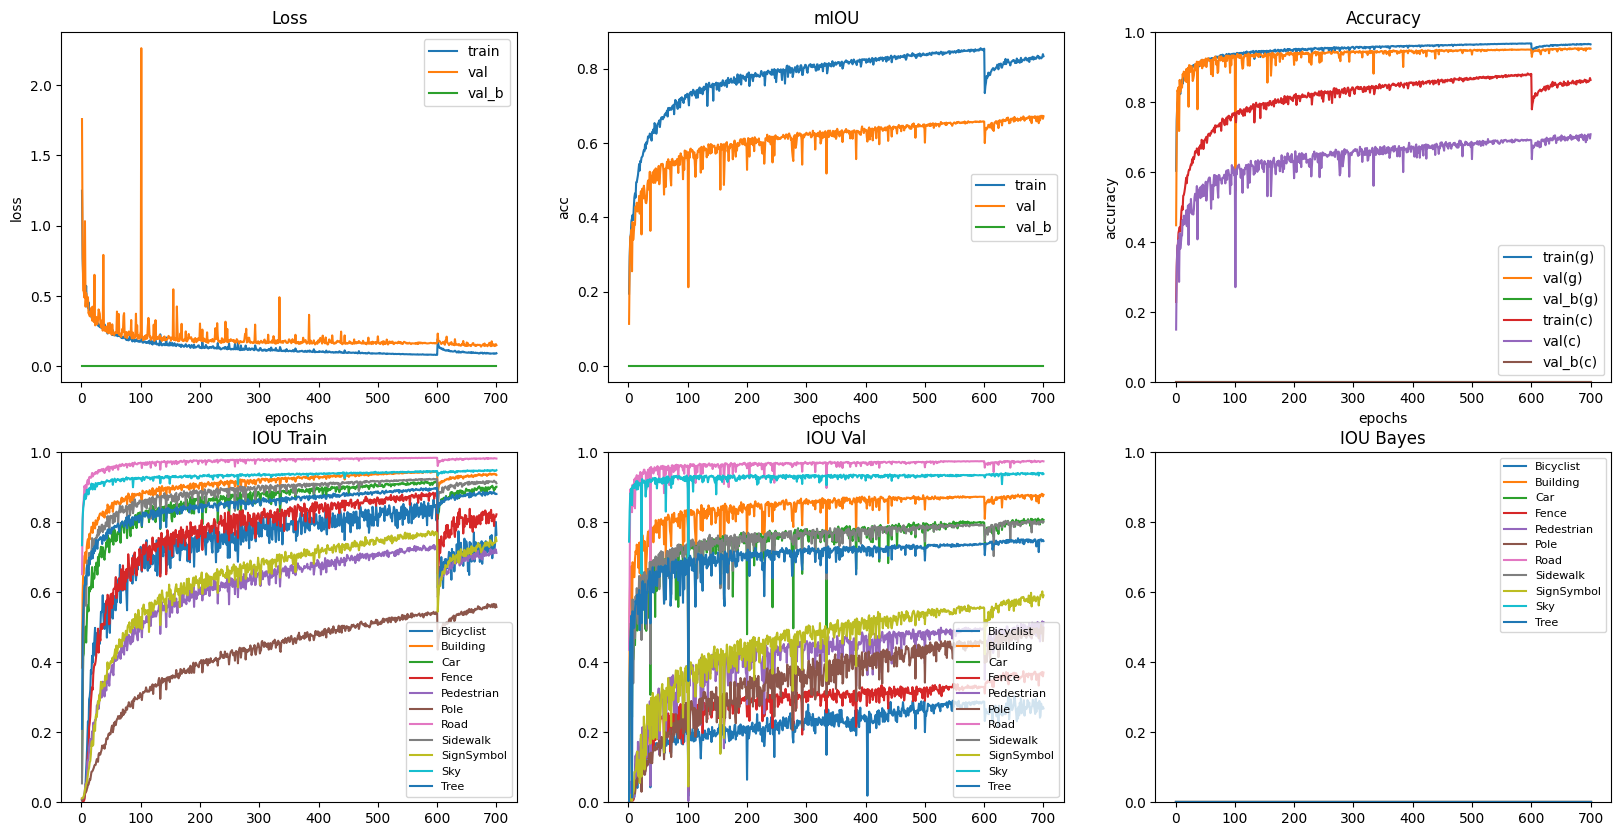

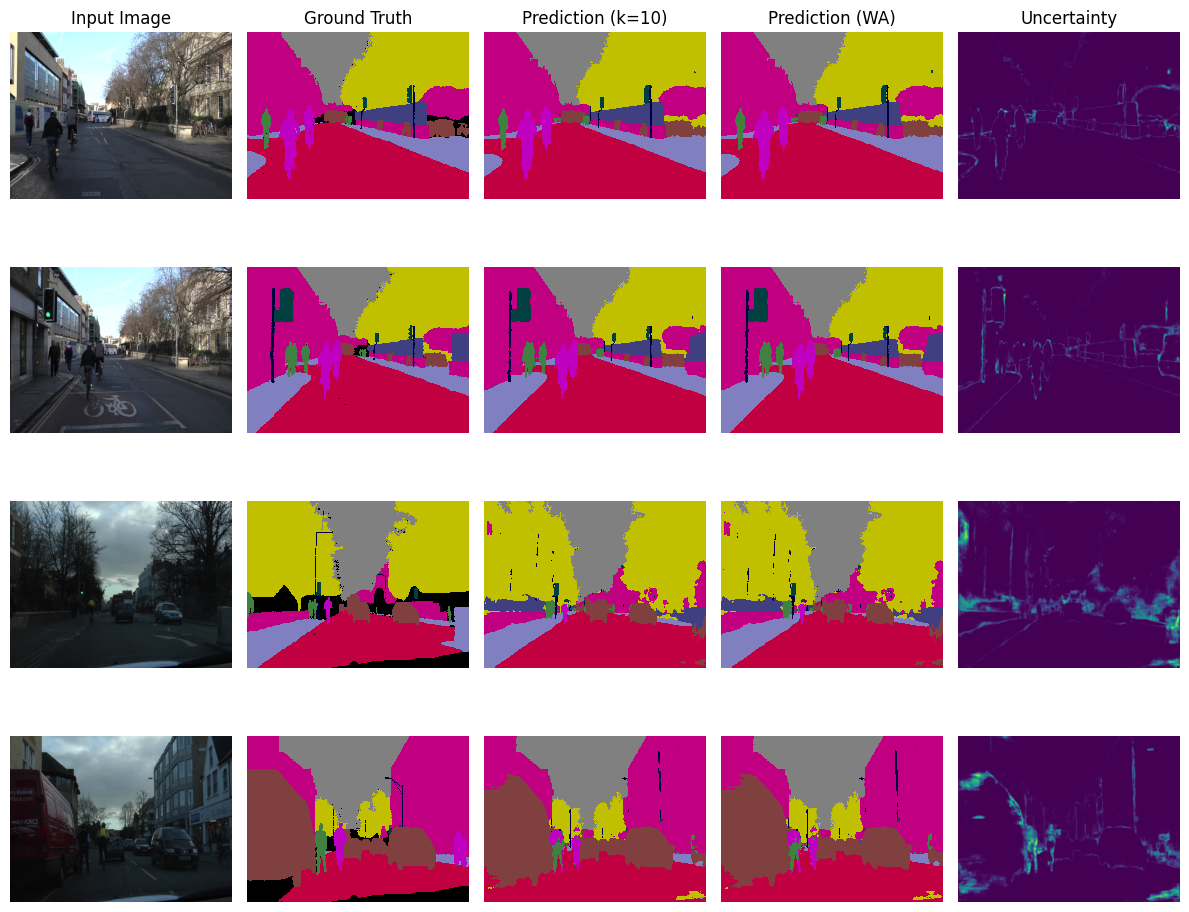

In [ ]:
# result_manager = ResultsManager(training_manager)
result_manager.save(
    save_properties=False,
    save_performance=True,
    save_calibration=False,
    save_pavpu=False,
)

result_manager.plot_qualitative_results(save=True)
# result_manager.plot_uncertainty_decomposition(save=True)

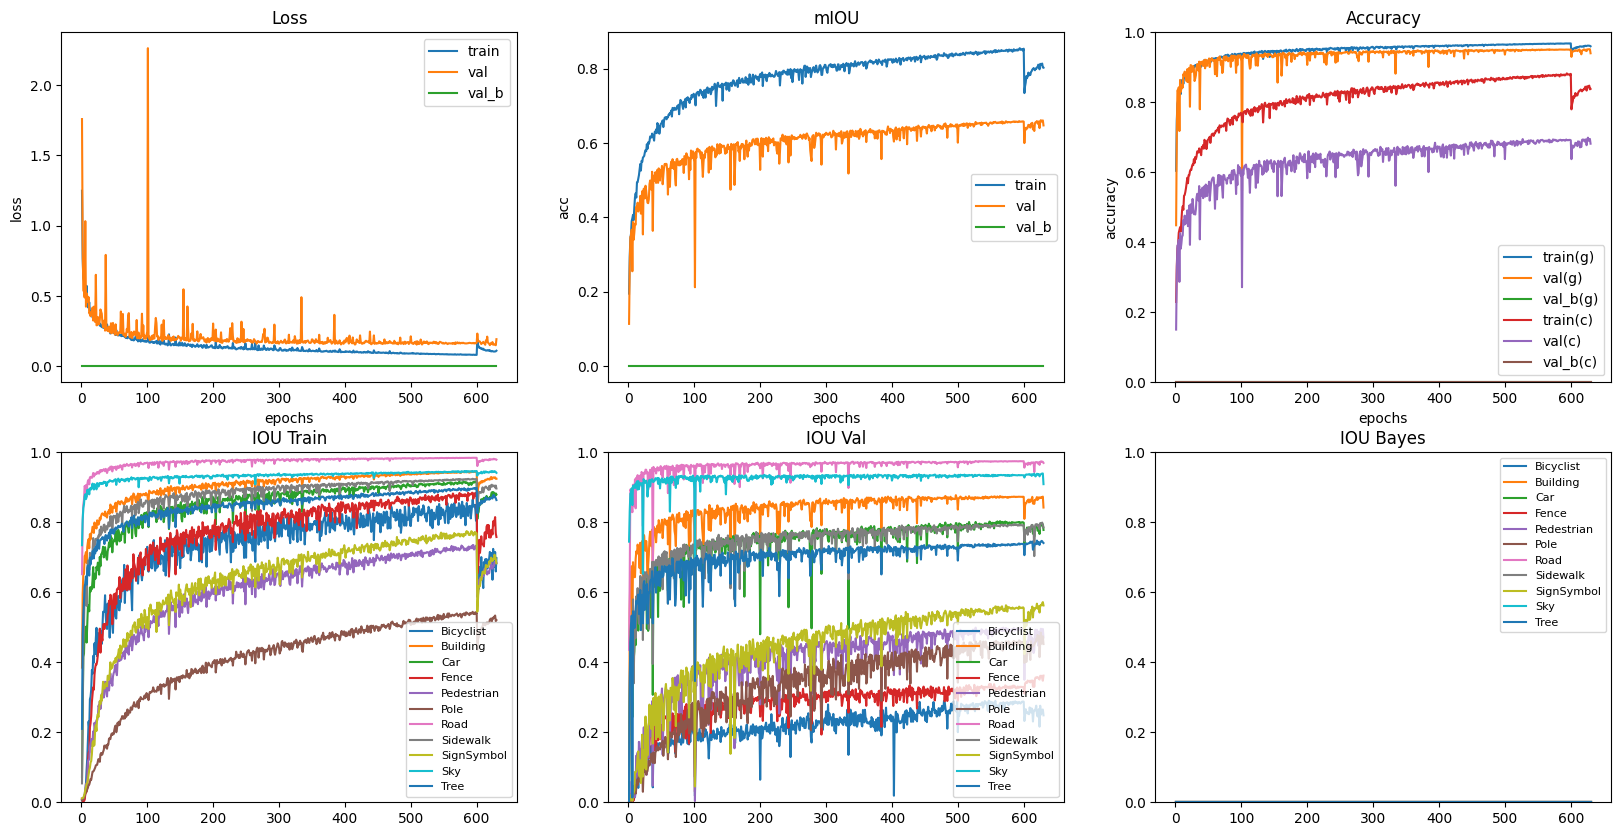

In [ ]:
result_manager.plot()

### Experiment 2

In [ ]:
torch.cuda.empty_cache()

config = {
    'experiment': '2-SE',
    'description': 'Baseline + squeeze & excitation',
    'dataset': 'Thesis',
    'num_classes': NUM_CLASSES,
    'input_dim': (HEIGHT, WIDTH),
    'width_mult': 1,
    'depth_mult': 1,
    'model': 'mobilenet-v2',
    'loss': 'CE',
    'lr': 1e-3,
    'scheduler': 'poly',
    'batch_size': 10,
    'total_epochs': 200,
    'weight_decay': 1e-4,
    'stochastic_depth_prob': 0,
    'use_se': True,
    'dropout_p': 0.1,
    'dropout_mode': 'linear', # linear, constant
    'dropout_loc': None, # None(default), middle, last
    'shallowDeconv': False,
    'skip_mode': 'upsample', # upsample (default), none, all
    'skip_op': 'concat',
    'last_channel': 0, # set to None for default, 0 to disable
    'k': 10,
    'eval_subset': None,
    'patience': 50,
}

training_manager = TrainingManager(dataset_manager.datasets, config)
result_manager = ResultsManager(training_manager)

In [ ]:
training_manager.train(epochs=200, eval_mode='regular')

In [ ]:
# result_manager = ResultsManager(training_manager)
result_manager.save(
    save_properties=True,
    save_performance=True,
    save_calibration=True,
    save_pavpu=True,
)

result_manager.plot_qualitative_results(save=True)
result_manager.plot_uncertainty_decomposition(save=True)

In [ ]:
from google.colab import runtime
runtime.unassign()

## Qualitative performance

In [ ]:
SAVE = True

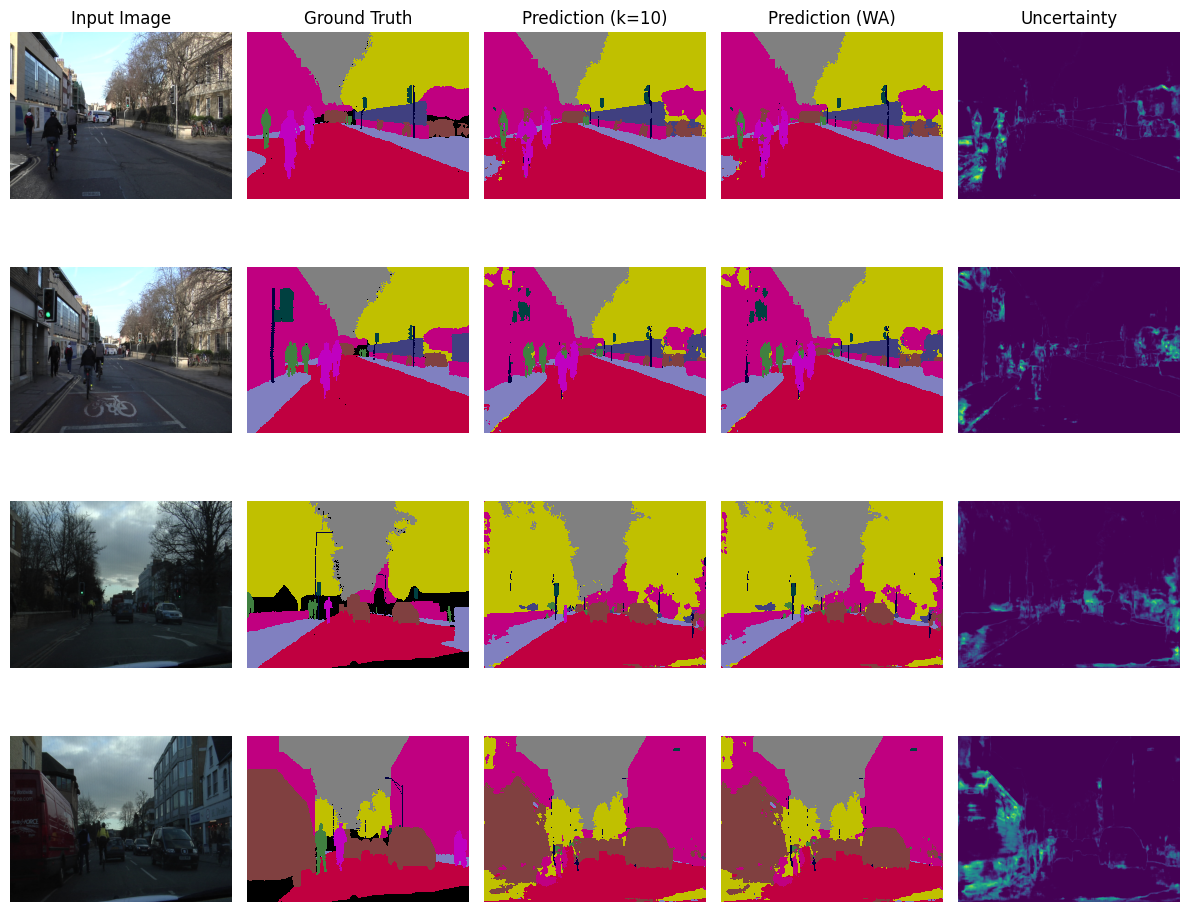

In [ ]:
result_manager.plot_qualitative_results(save=False)

## Uncertainty Decomposition

In [ ]:
result_manager.plot_uncertainty_decomposition(save=False)

## Additional Plots

### Plot acc vs k

In [ ]:
# result_manager = ResultsManager(training_manager)
torch.cuda.empty_cache()
result_manager.plot_acc_vs_k(ks=[20, 10, 5, 1], num_repeats=1, save=True)

### Reliability plot

In [ ]:
# plot_calibration(training_manager.net, dataloaders['test'], ks=[0, 1, 5, 20], num_buckets=50)
# plt.savefig(result_manager)
# result_manager = ResultsManager(training_manager)

result_manager.plot_calibration(
    num_buckets=10,
    dataloader=dataloaders['test'],
    net=training_manager.net,
    ks=[0, 5, 10],
    save=False
)

In [ ]:
SAVE=True

In [ ]:
result_manager.config

### PAvPU

Directory at /content/drive/MyDrive/ShorelineNet_pytorch/results/Thesis/1-decoder-dw already exists and contains 10 items
saving config...
computing uncertainty ranges...


  0%|          | 0/100 [00:00<?, ?it/s]

WA: min=1.1471894140413497e-05, max=2.2595698833465576
PE: min=2.2360991351888515e-05, max=2.252326488494873
MI: min=4.0322993299923837e-07, max=0.5439916849136353
computing pavpu on test set...


  0%|          | 0/232 [00:00<?, ?it/s]

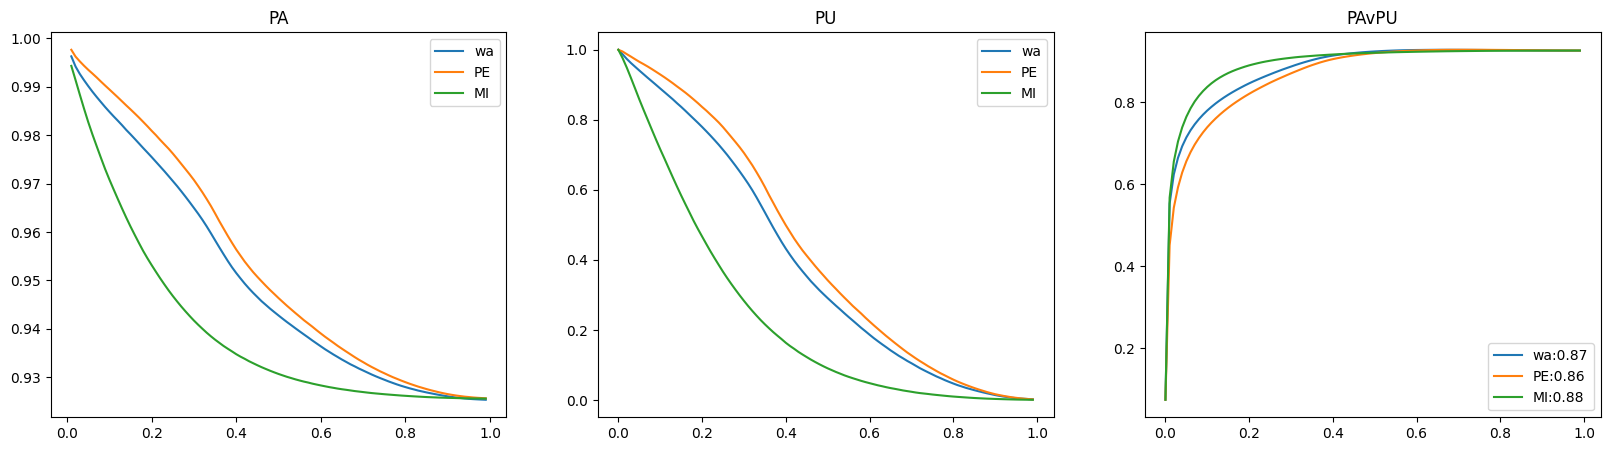

In [ ]:
torch.cuda.empty_cache()
result_manager = ResultsManager(training_manager)

output = result_manager.compute_and_plot_PAvPU(k=10, window=4, save=False)

In [ ]:
torch.cuda.empty_cache()

result_manager = ResultsManager(training_manager)

output = result_manager.compute_and_plot_PAvPU_prob(k=10, window=1, save=False)

In [ ]:
# def PAvPU(gt: Tensor,
#           pred: Tensor,
#           uncertainty: Tensor,
#           min_uncertainty: float,
#           max_uncertainty: float,
#           acc_threshold: Optional[float]=0.5,
#           window: Optional[int]=4,
#           num_buckets=100)->float:

output = PAvPU(y, y_pred, mutual_info, 0, 0.5, 0.5, window=4, num_buckets=50)

In [ ]:
print(mutual_info.mean())
print(mutual_info.std())

print(entropy.mean())
print(entropy.std())



In [ ]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plt.plot(output[0])

plt.subplot(1, 3, 2)
plt.plot(output[1])

plt.subplot(1, 3, 3)
plt.plot(output[2])

In [ ]:
# WA: min=5.964948712744444e-08, max=2.3146274089813232
# PE: min=2.8625896675293916e-07, max=2.311171531677246
# MI: min=-6.530444807140157e-08, max=0.6384855508804321

# WA: min=5.964948712744444e-08, max=2.3146274089813232
# PE: min=3.0355587909980386e-07, max=2.3152565956115723
# MI: min=-9.023187885759398e-08, max=0.6919202208518982


output.keys()


In [ ]:
output['pa/PE']